# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sweetviz -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [37]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, make_scorer
import phik
from phik.report import plot_correlation_matrix
import os
from pathlib import Path
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

# создание константы RANDOM_STATE
RANDOM_STATE = 42
# размер тестовой выборки TEST_SIZE
TEST_SIZE = 0.25

## Подготовка данных

In [5]:
def loading_info(pth):
    """
    Функция загрузки датасетов и 
    """
    if os.path.exists(pth):
        #загрузка данных из файла
        data = pd.read_csv(pth)
        # отобразим загруженные датасеты
        display(data.head())
        # отобразим основную
        display(data.info())
        return data
    else:
        print(f"Не верный путь к файлу: {pth}")

In [6]:
# пути к файлам с датасетами
pth = '/datasets/autos.csv'

autos = loading_info(pth)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

                                             |          | [  0%]   00:00 -> (? left)


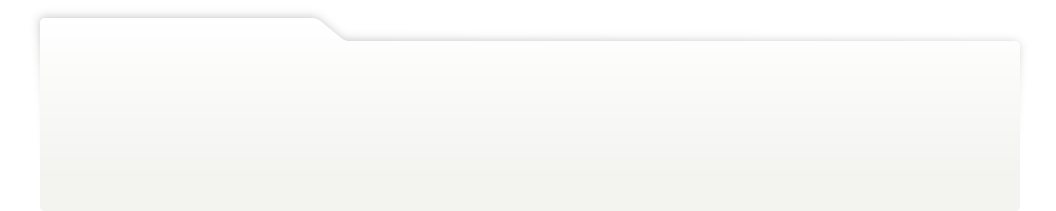
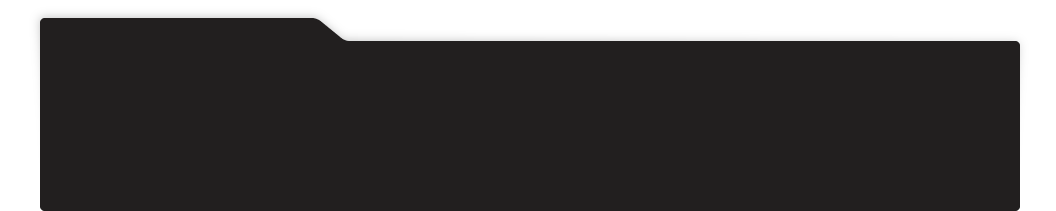
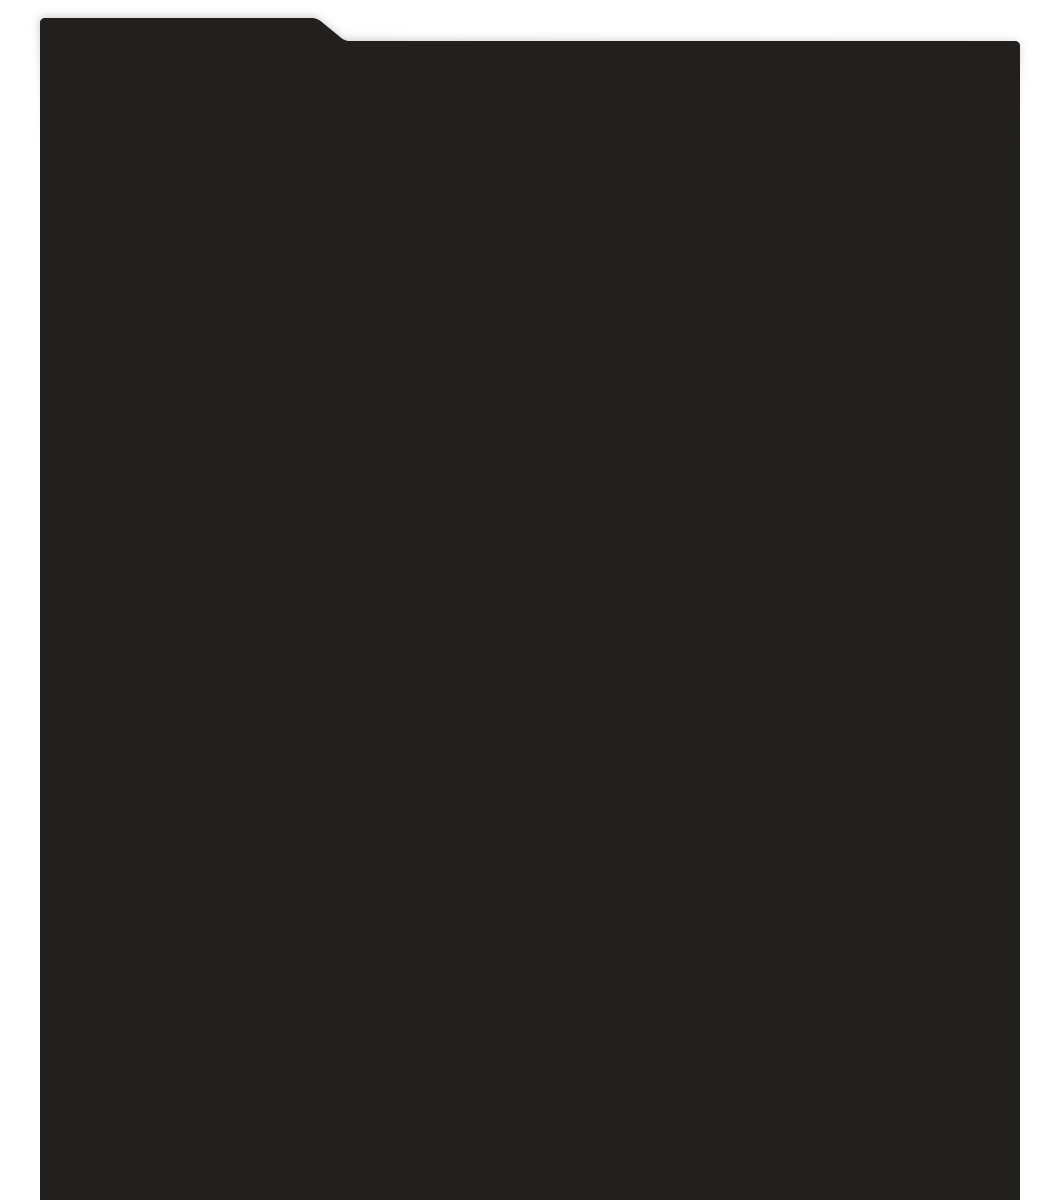
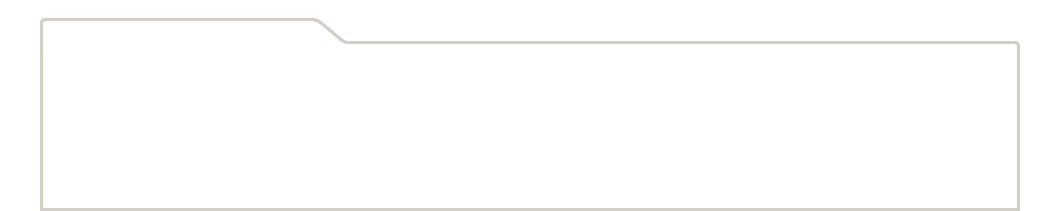
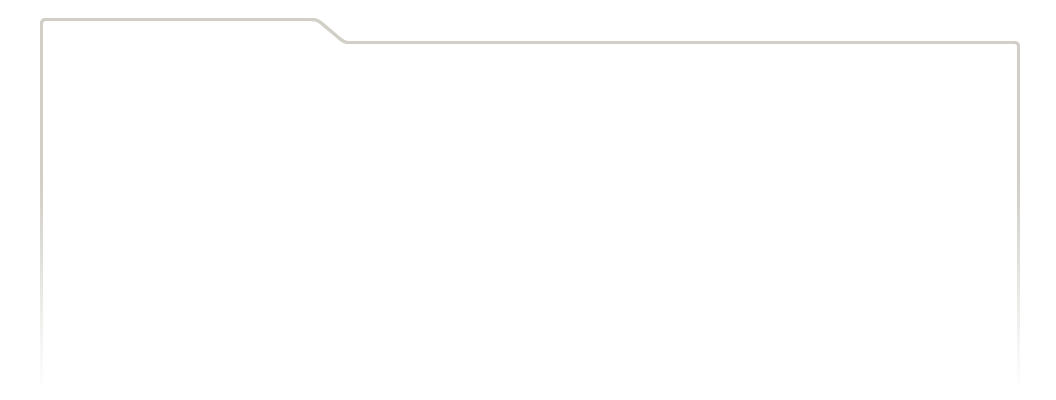
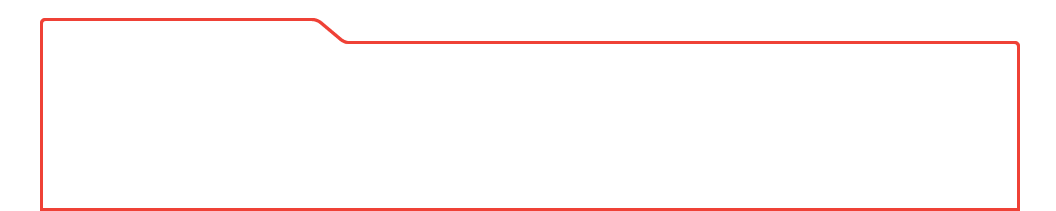
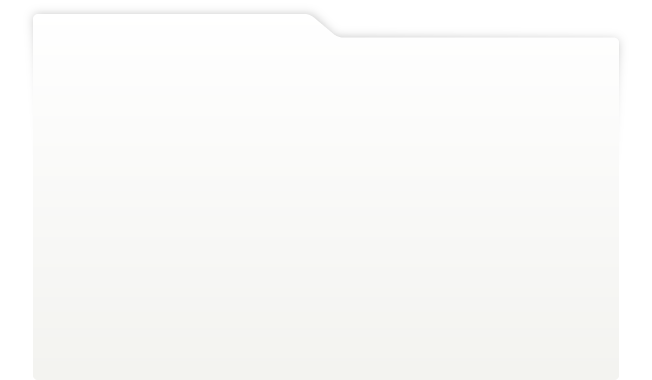
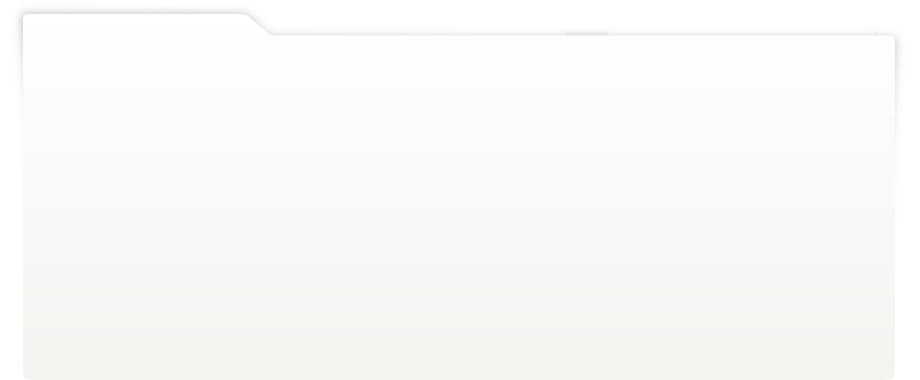
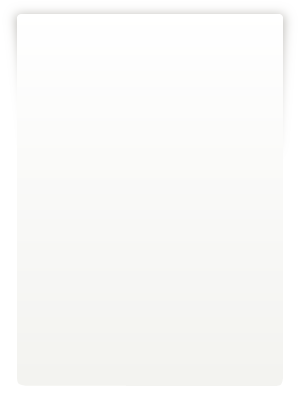
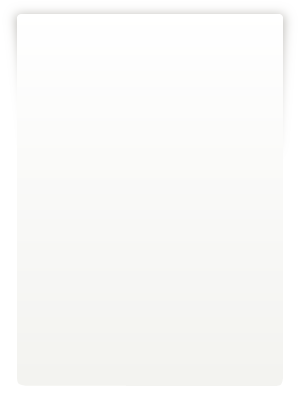
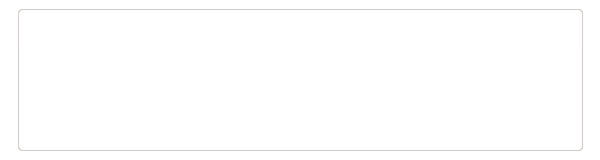
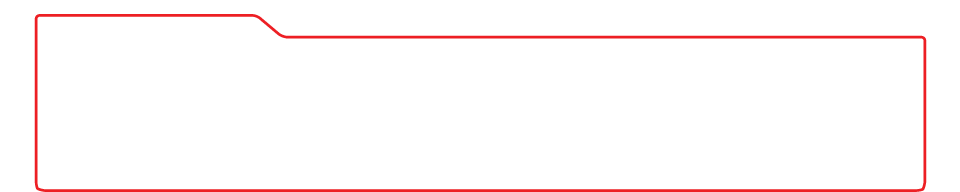
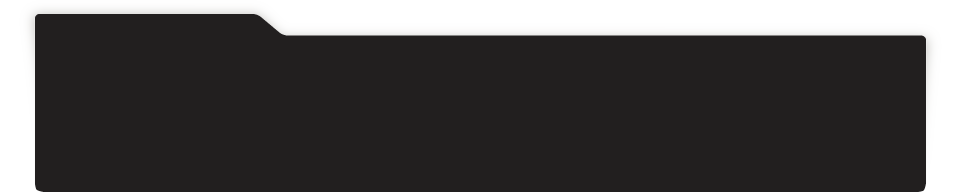
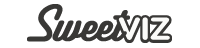
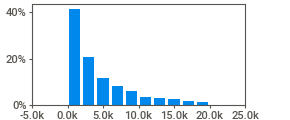
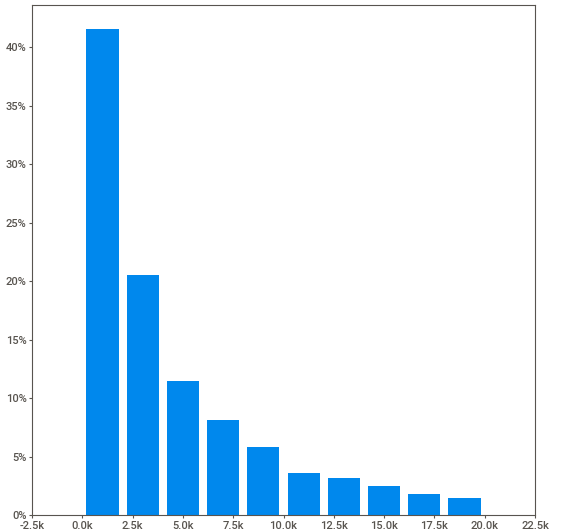
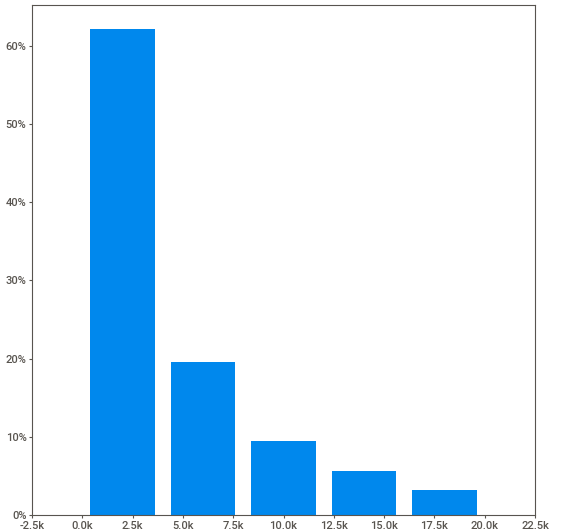
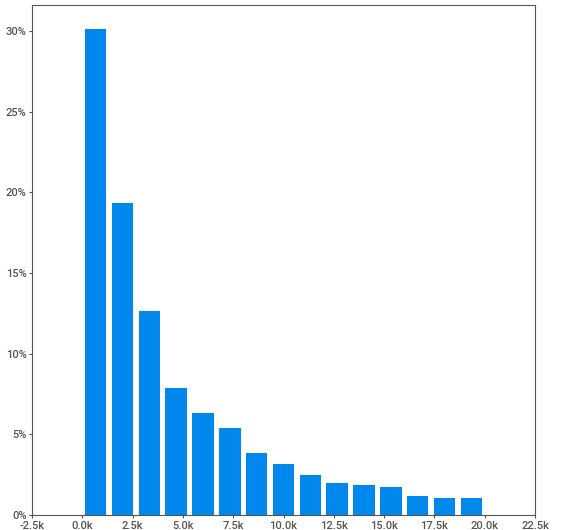
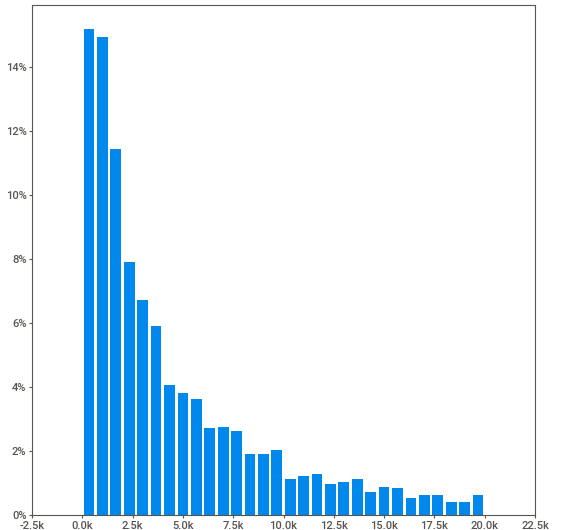
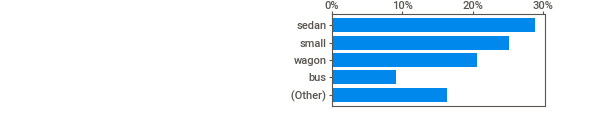
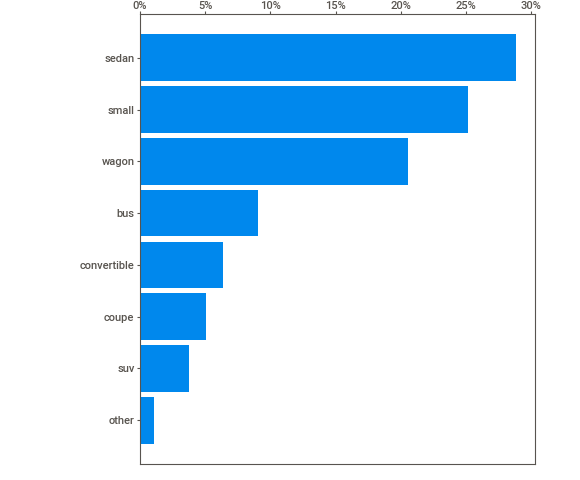
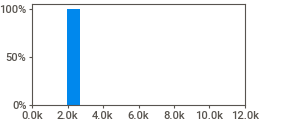
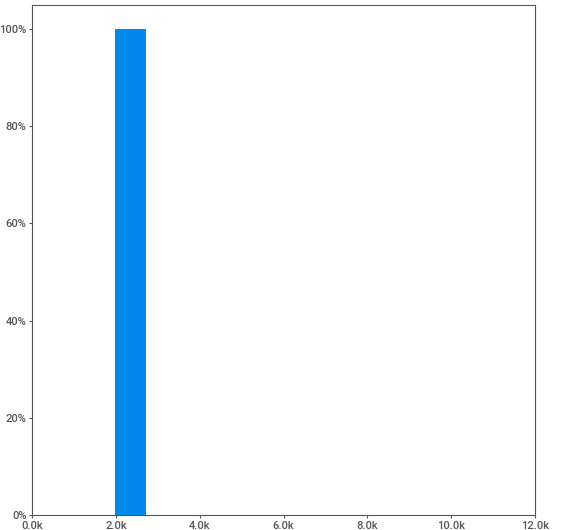
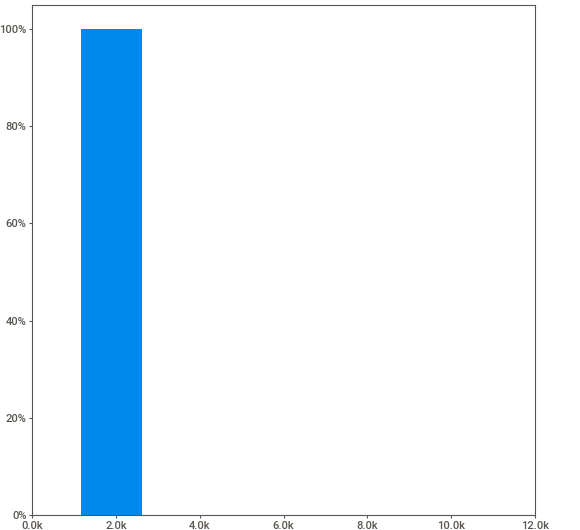
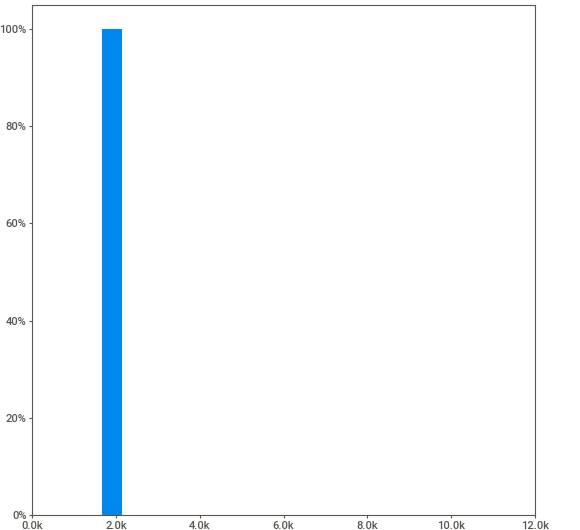
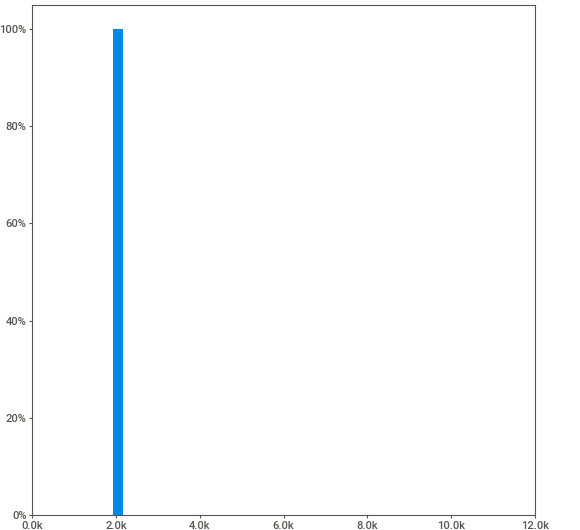
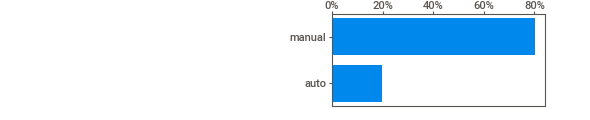
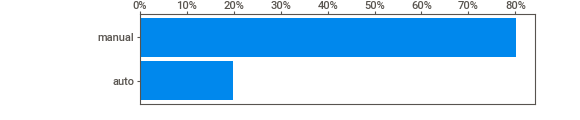
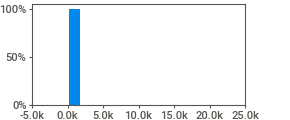
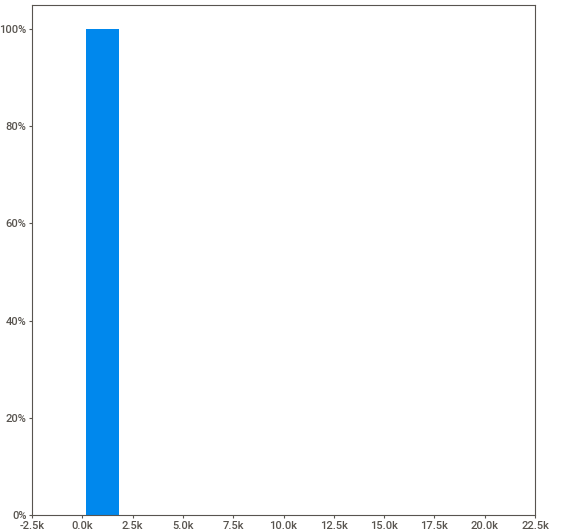
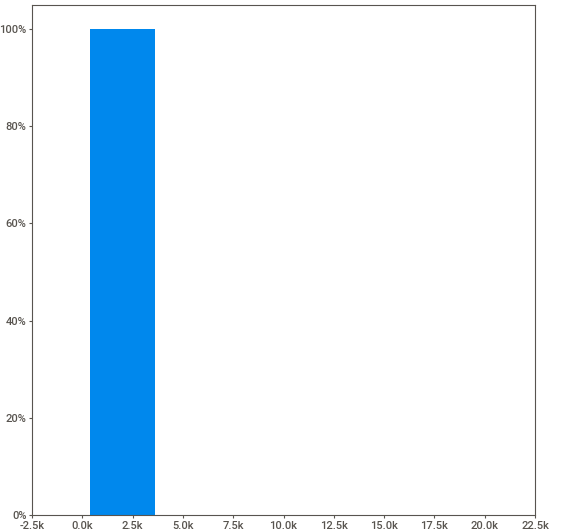
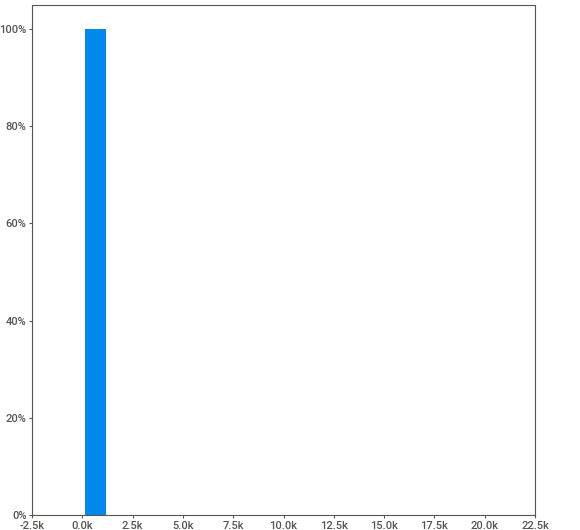
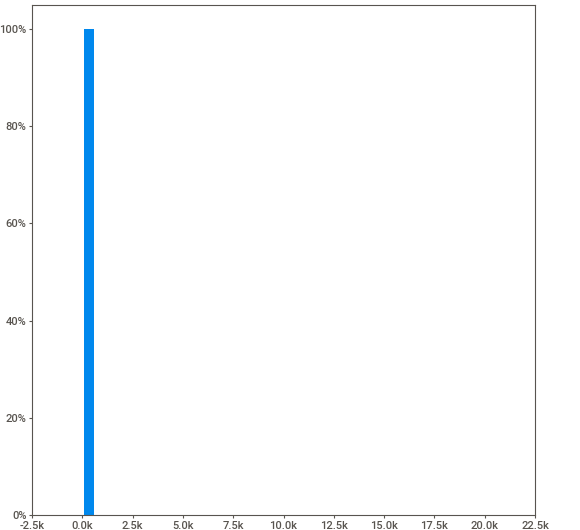
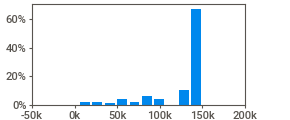
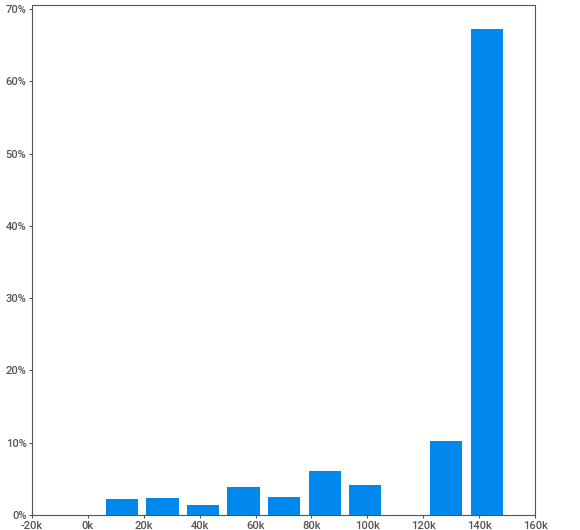
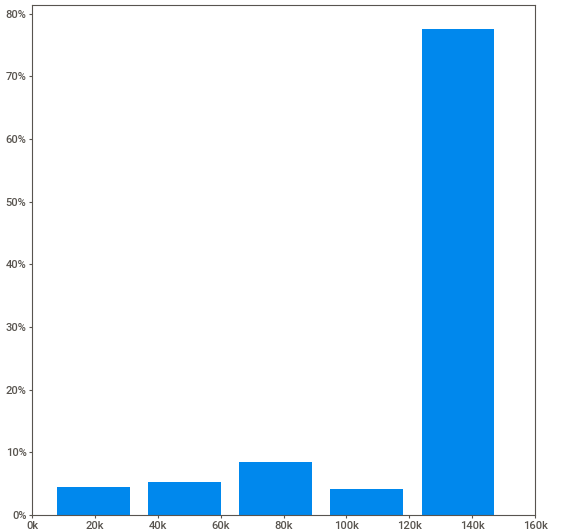
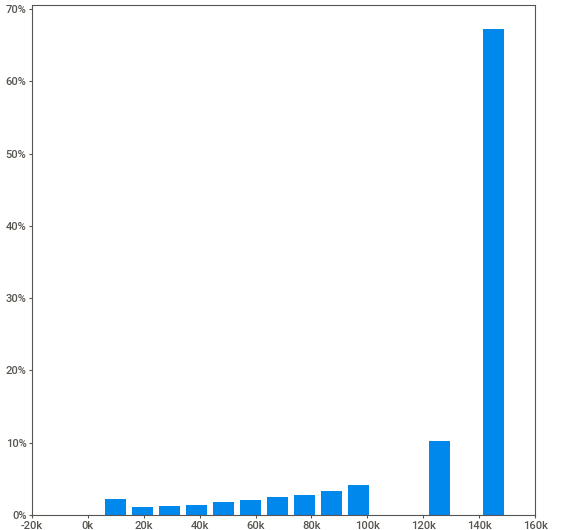
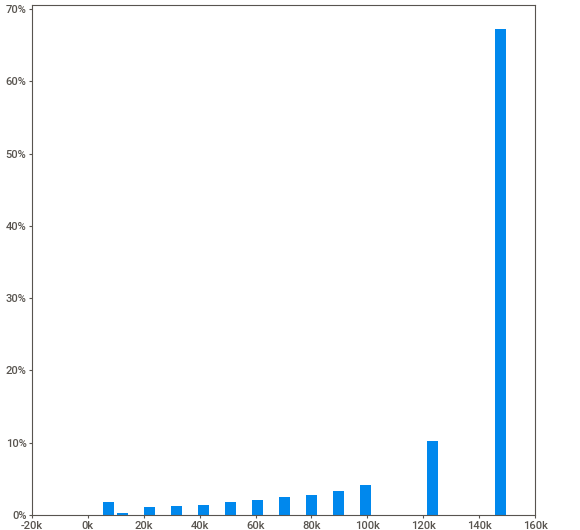
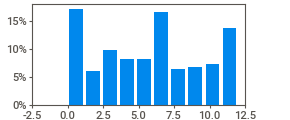
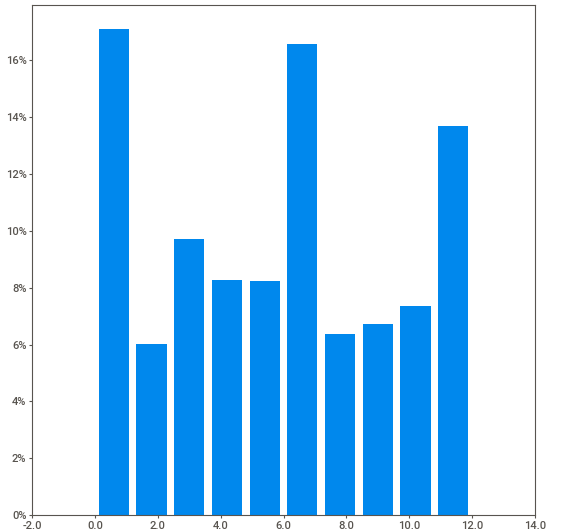
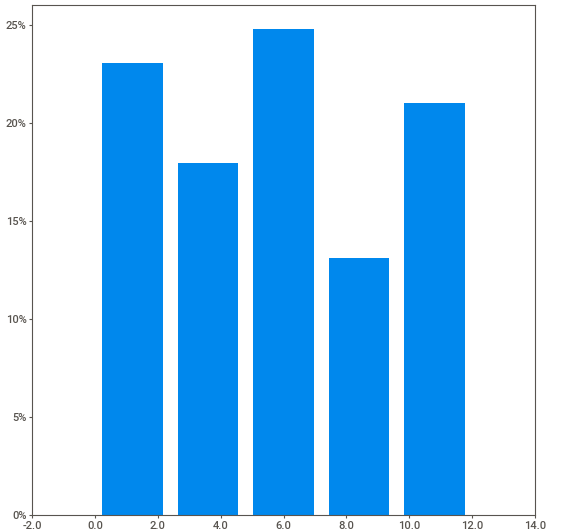
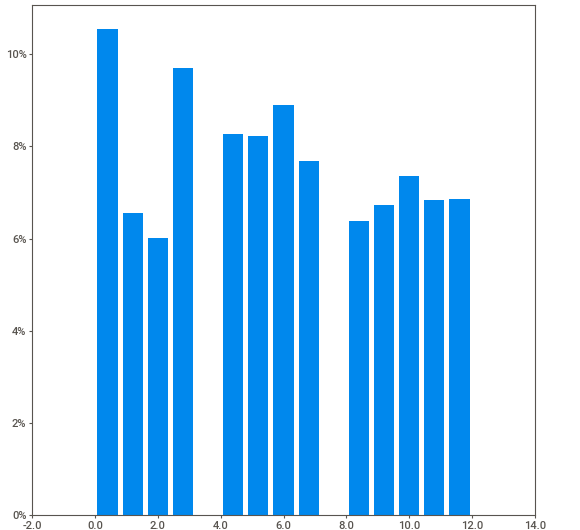
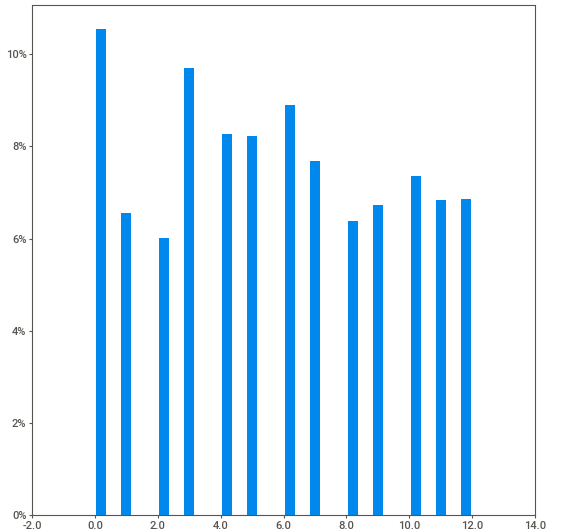
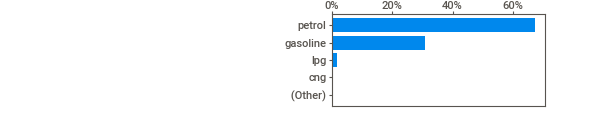
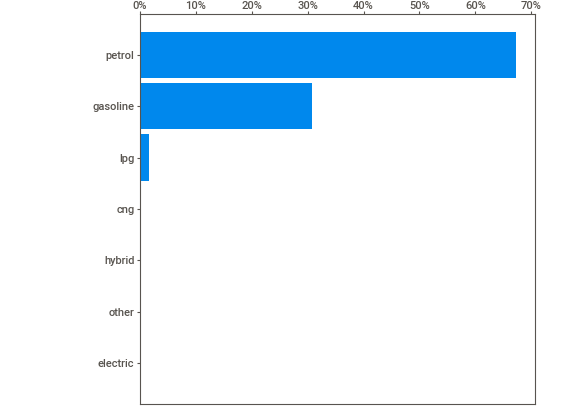
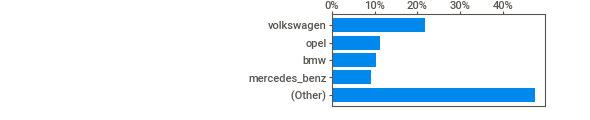
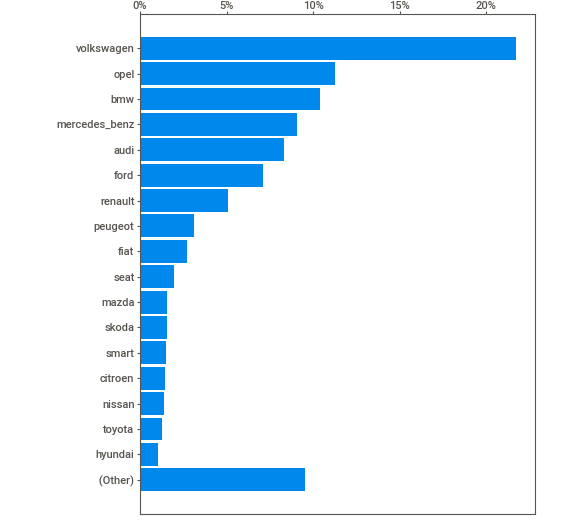
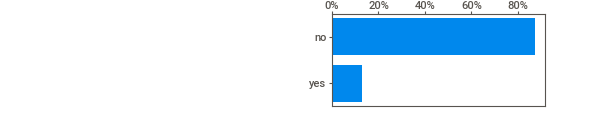
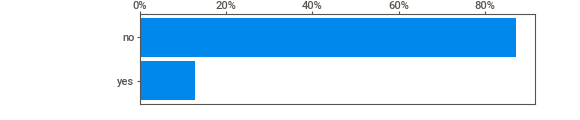
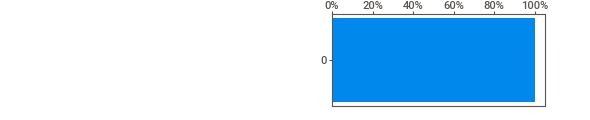
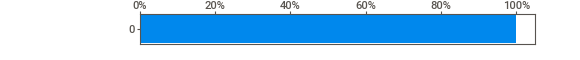
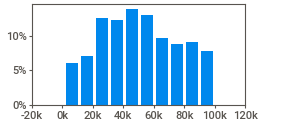
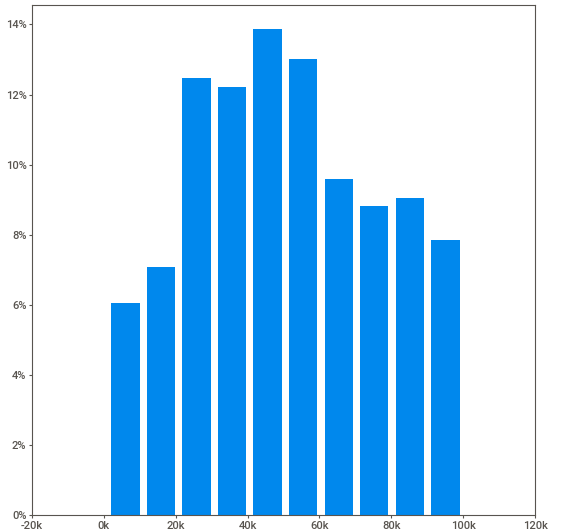
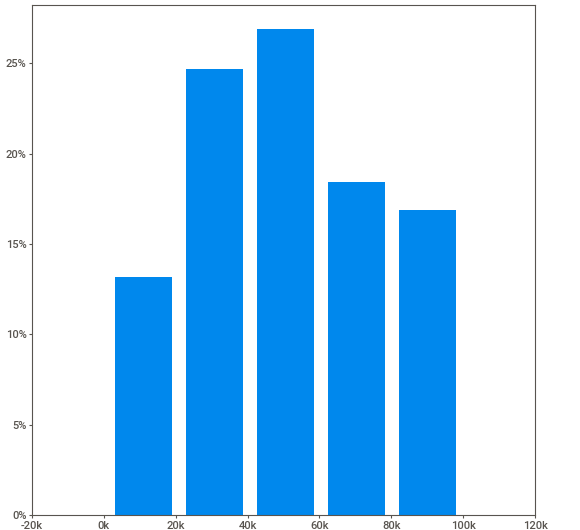
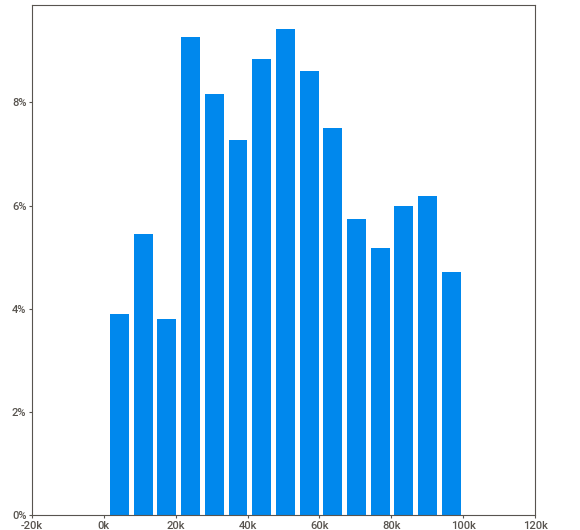
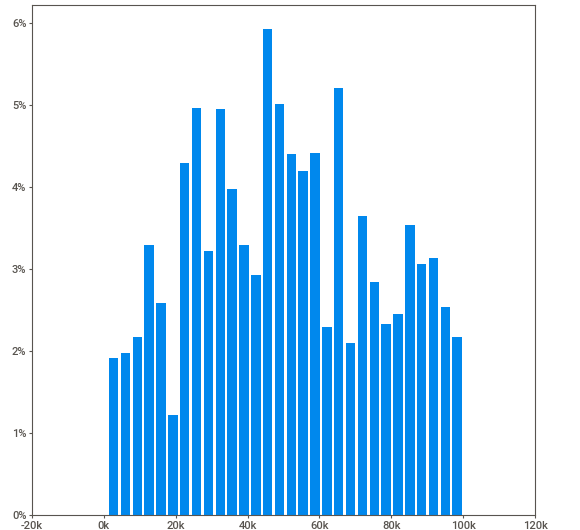
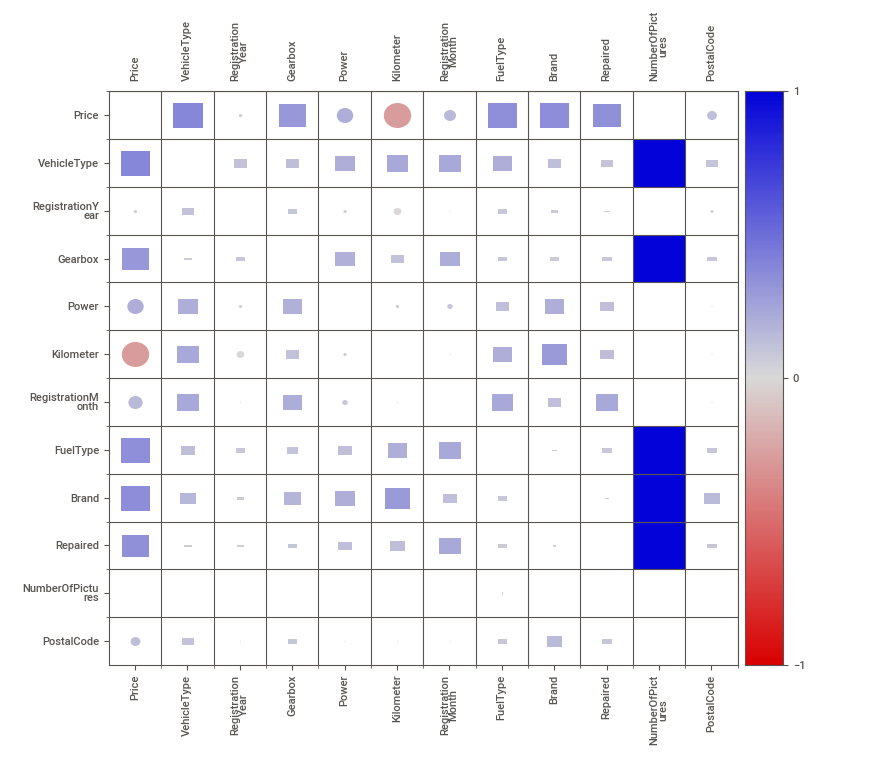
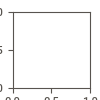

In [7]:
report = sv.analyze(autos)
report.show_notebook()

- удалим неинформативные столбцы, которые не влияют на стоимость автомобиля (DateCrawled - дата скачивания анкеты из базы, DateCreated — дата создания анкеты, NumberOfPictures — количество фотографий автомобиля, PostalCode - почтовый индекс владельца анкеты (пользователя), LastSeen — дата последней активности пользователя, RegistrationMonth - месяц регистрации автомобиля;
- удалить строки, где значение price равно 0 и меньше 200, так как стоимость машины не может быть равна столь маленькой, заменять эти данные на медиану не целесообразно у целевой переменной;
- мощность машины не может быть равна 0, быть слишком маленькой и слишком большой, поэтому все значения меньше 40 и больше 600 удалим;
- ограничим год регистрации автомобиля от 1960, так как первые автомобили начали регистрировать примерно в это время до 2016 года, то есть до времени выгрузки данных, все остальные значения будем считать аномалиями;
- заполним пропуски в столбцах VehicleType, Model заглушкой unknown;
- пропуски в остальных столбцах запоним с помощью энкодера в паплайне.

In [8]:
drop_column = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'RegistrationMonth', 'PostalCode']
autos = autos.drop(drop_column, axis=1)

In [9]:
autos = autos.query('Price > 200')

In [10]:
autos['Model'] = autos['Model'].fillna('unknown')

In [11]:
autos['Model'].isna().sum()

0

In [12]:
autos = autos.query('Power < 600 and Power > 40')

In [13]:
autos = autos.query('RegistrationYear < 2017 and RegistrationYear > 1960')

In [14]:
autos['VehicleType'] = autos['VehicleType'].fillna('unknown')

In [15]:
autos['VehicleType'].isna().sum()

0

In [16]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer
count,289739.000000,289739.000000,289739.000000,289739.000000
mean,4944.412696,2002.988959,121.766521,128397.816656
std,4610.512961,6.274413,53.470269,36530.568298
min,202.000000,1961.000000,41.000000,5000.000000
25%,1400.000000,1999.000000,80.000000,125000.000000
50%,3299.000000,2003.000000,115.000000,150000.000000
75%,7000.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,585.000000,150000.000000


Построим матрицу корреляции учитывая категориальные признаки.

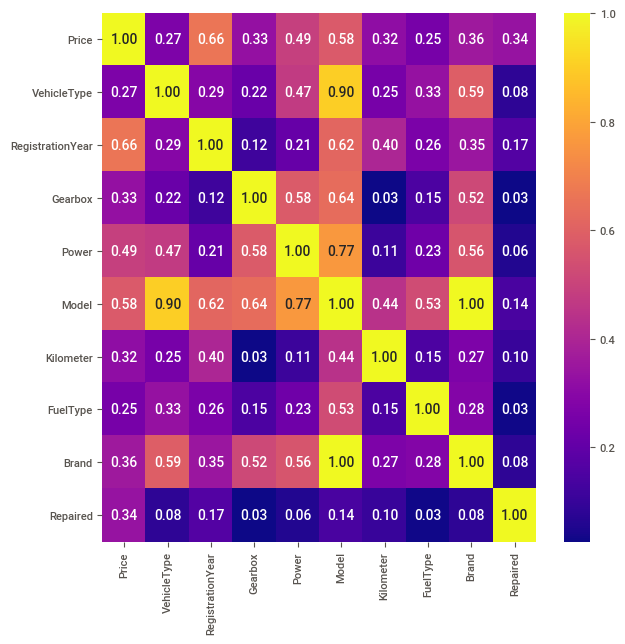

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(autos.phik_matrix(interval_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer']), annot=True, fmt='.2f', cmap='plasma'
)
plt.show()

В входных признаках присутствует мультиколлинеарность. Между признаками Model и VehicleType - 0.90, Model и Brand - 1. Так как Model больше всех коррелирует с целевой переменной, удалим Brand. VehicleType пока оставим, хоть и корреляция 0.9, что граничит с мультиколлинеарностью.

<div class="alert alert-info">
Исправила.
</div>

In [18]:
drop_column_multi = ['Brand']
autos = autos.drop(drop_column_multi, axis=1)

<div class="alert alert-info">
Убрала.
</div>

                                             |          | [  0%]   00:00 -> (? left)


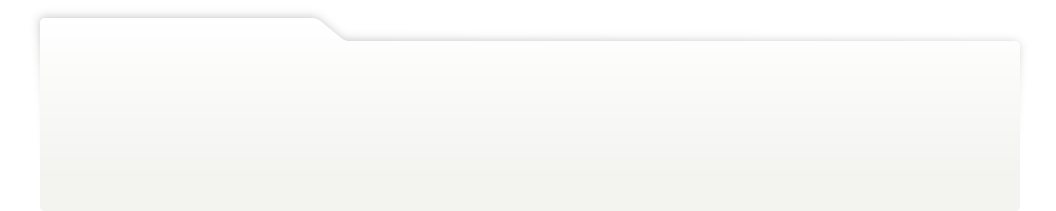
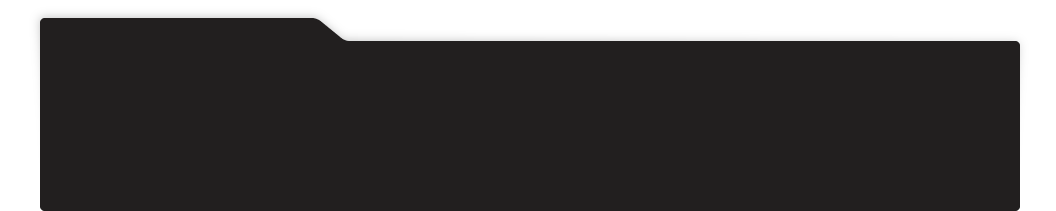
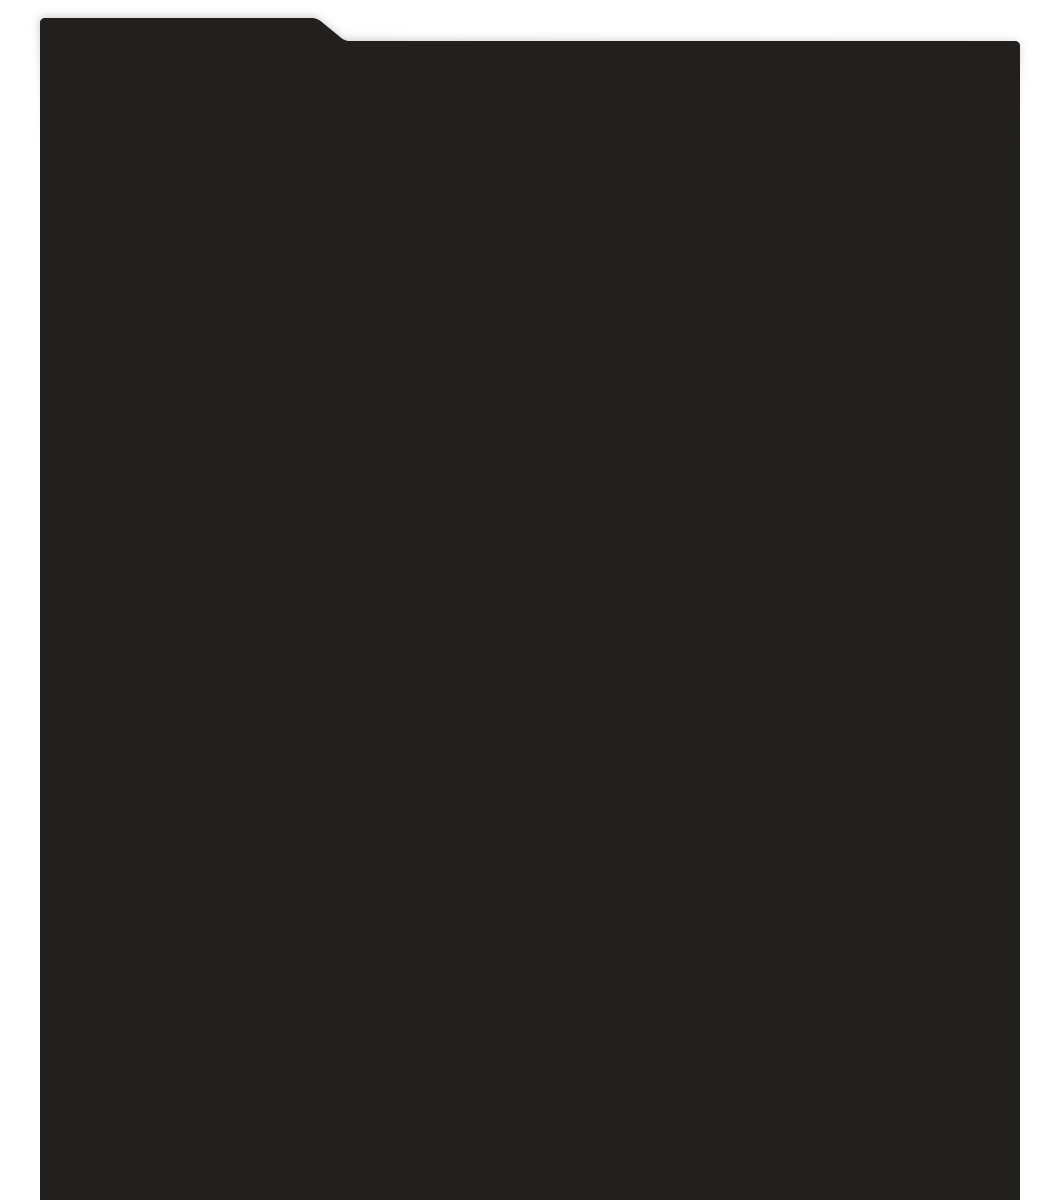
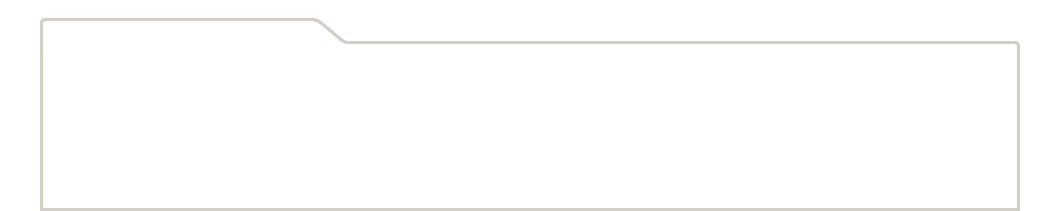
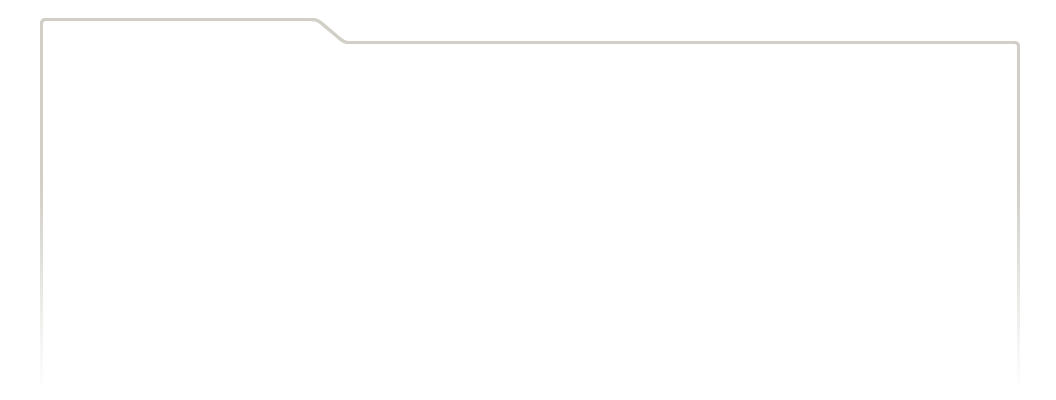
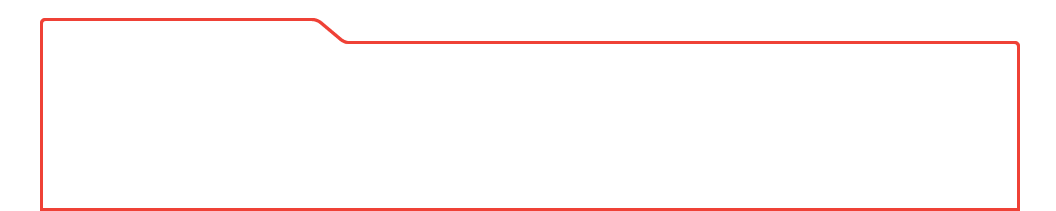
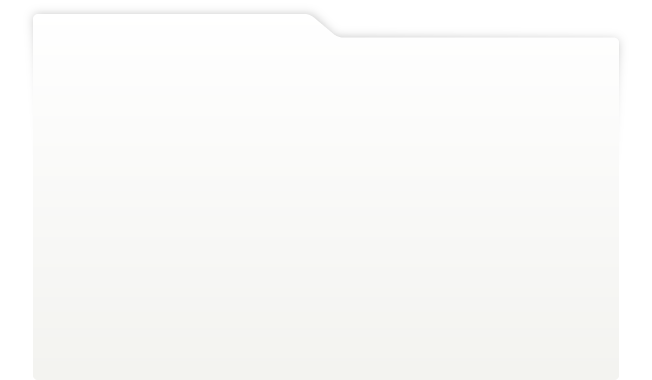
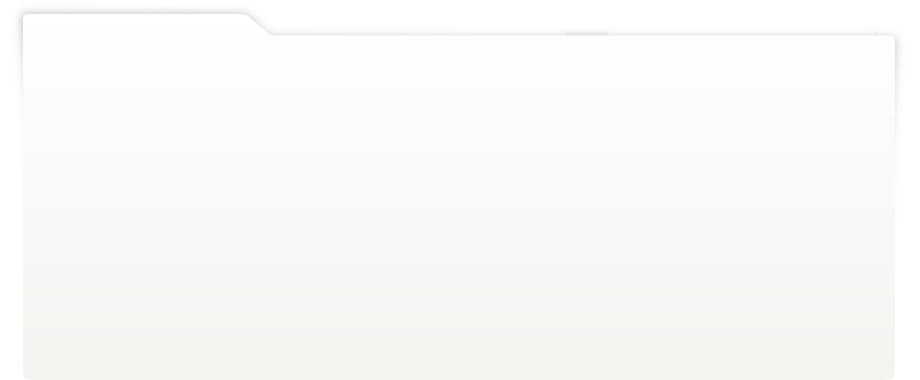
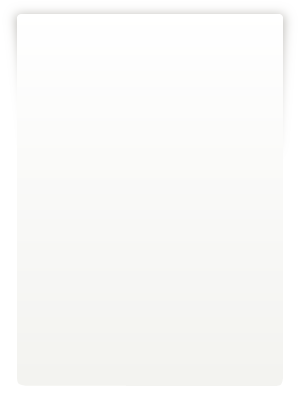
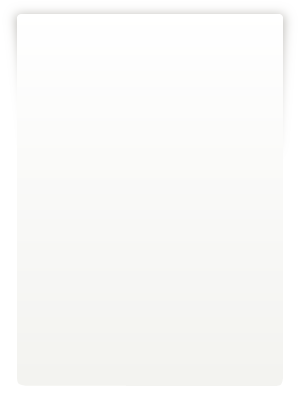
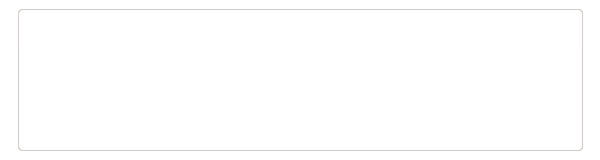
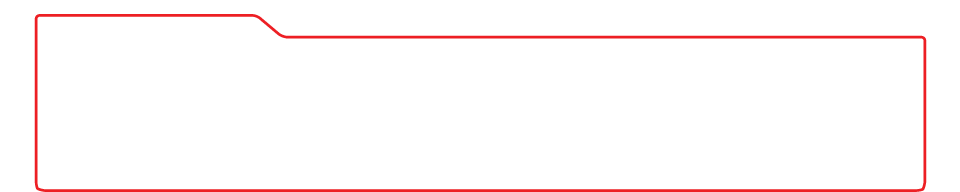
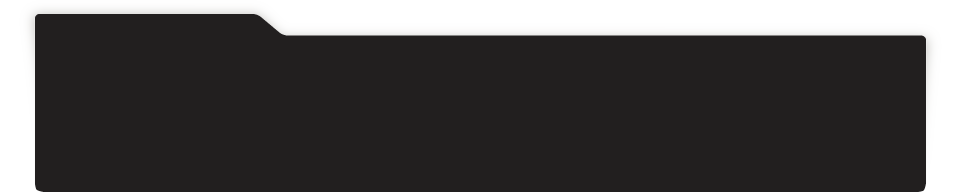
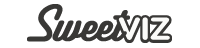
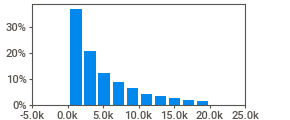
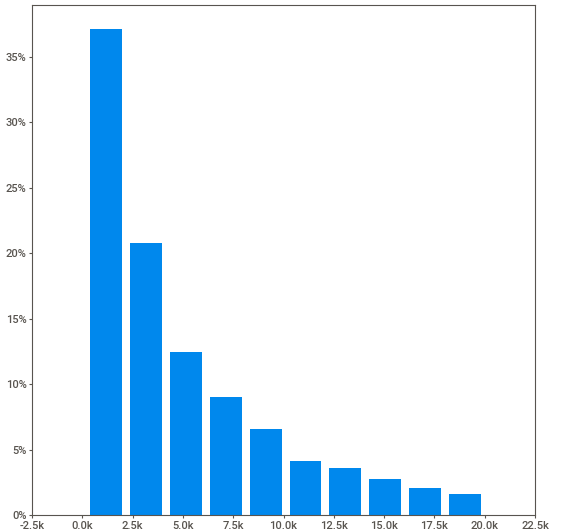
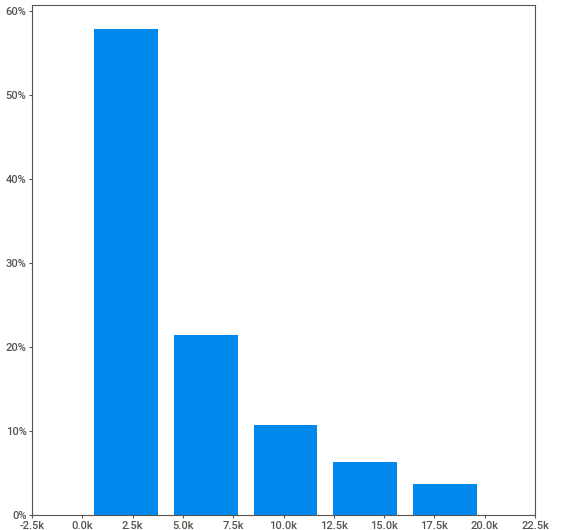
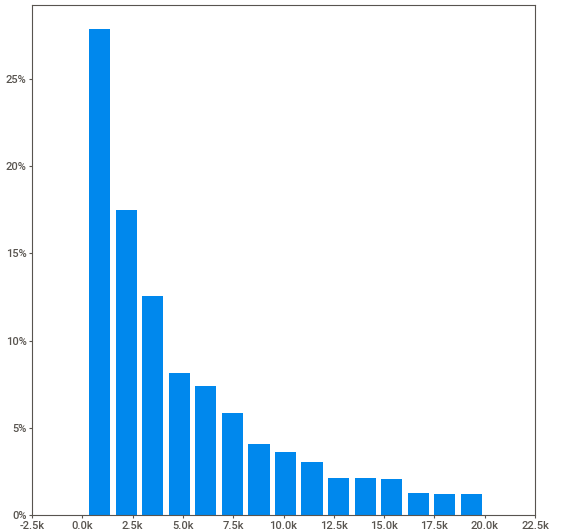
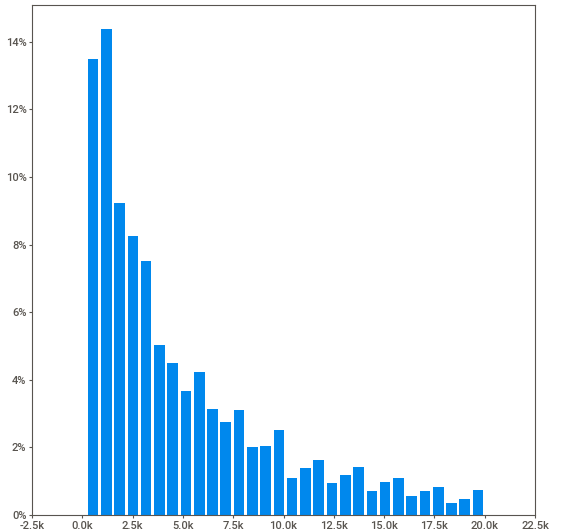
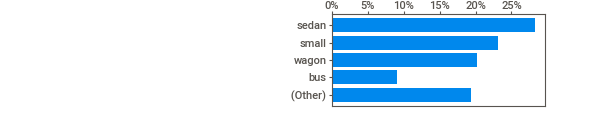
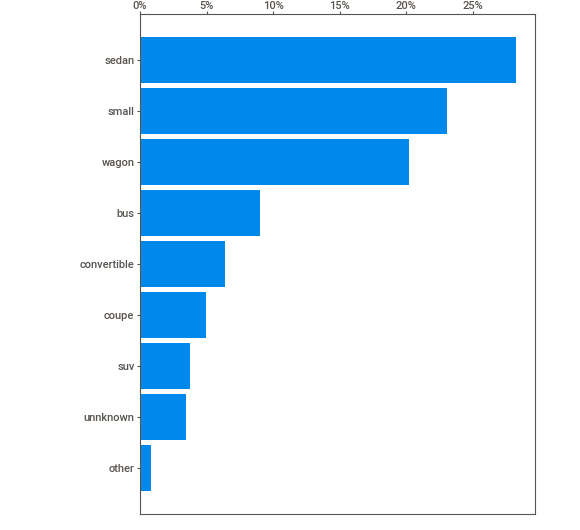
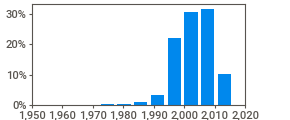
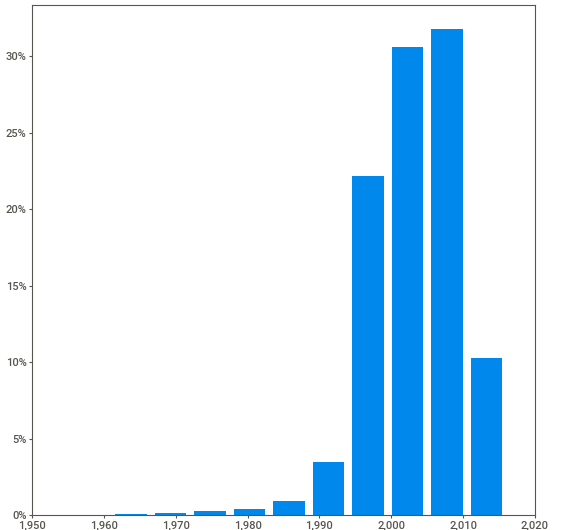
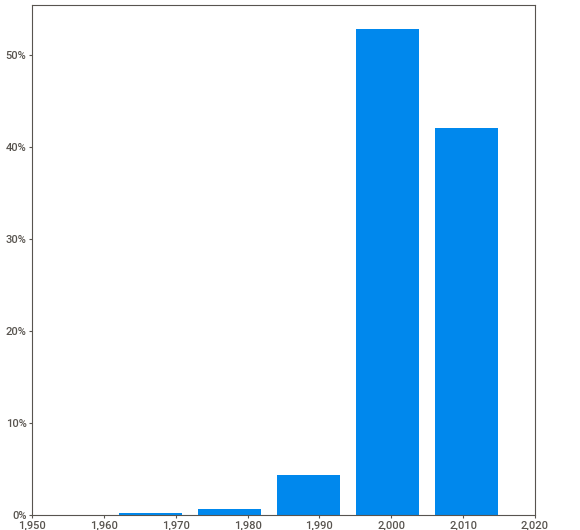
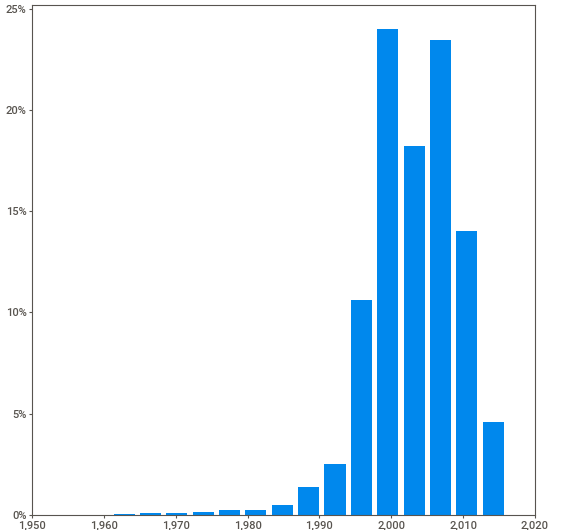
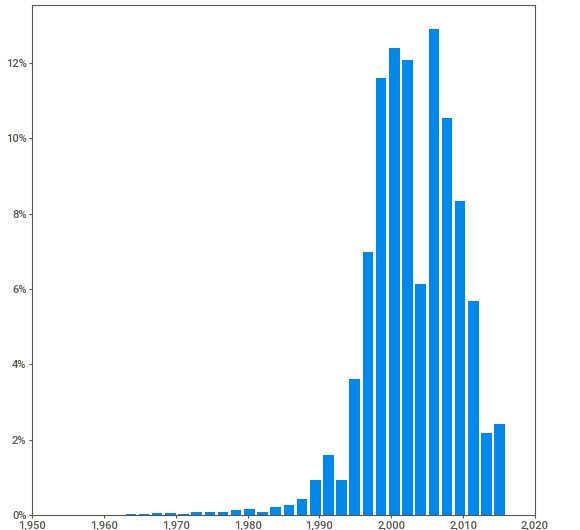
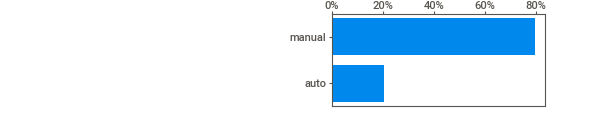
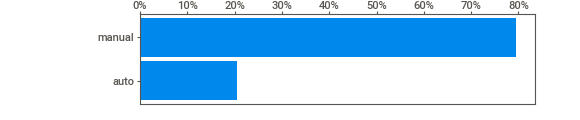
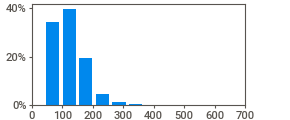
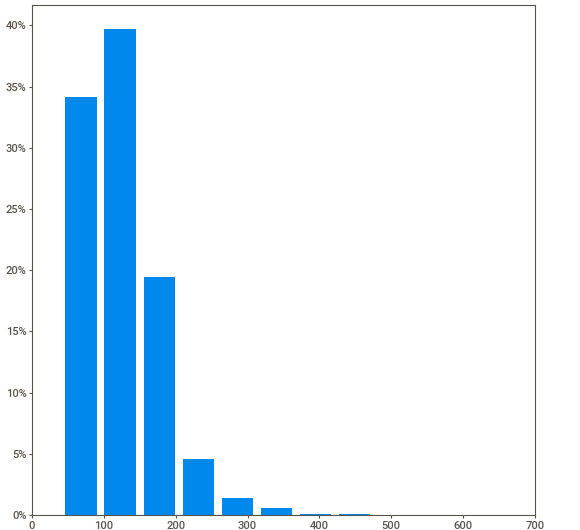
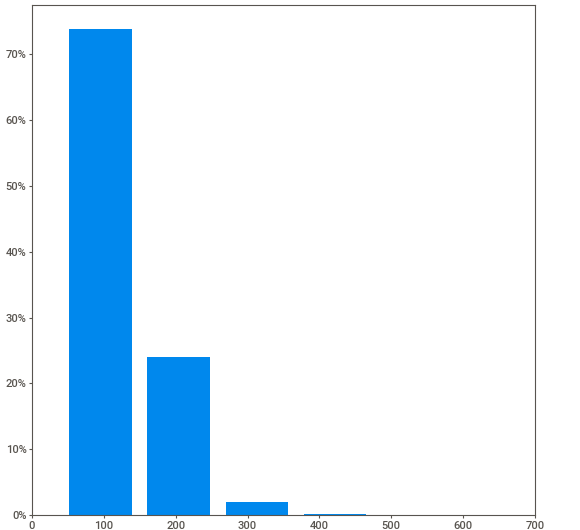
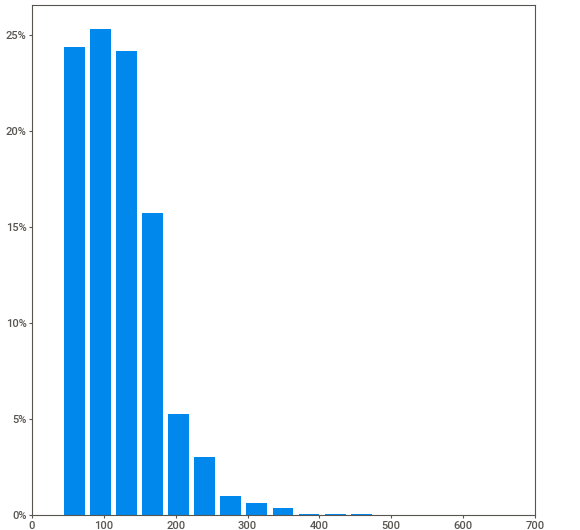
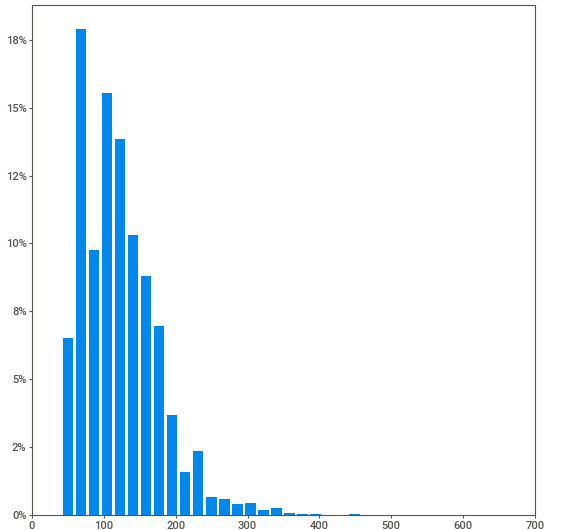
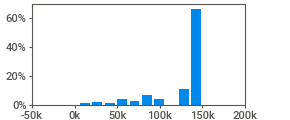
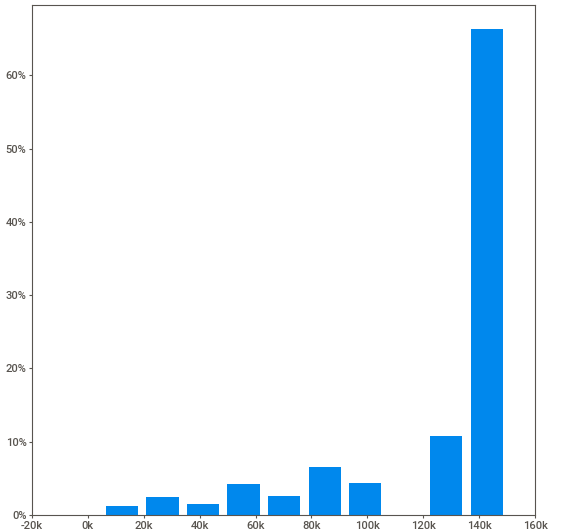
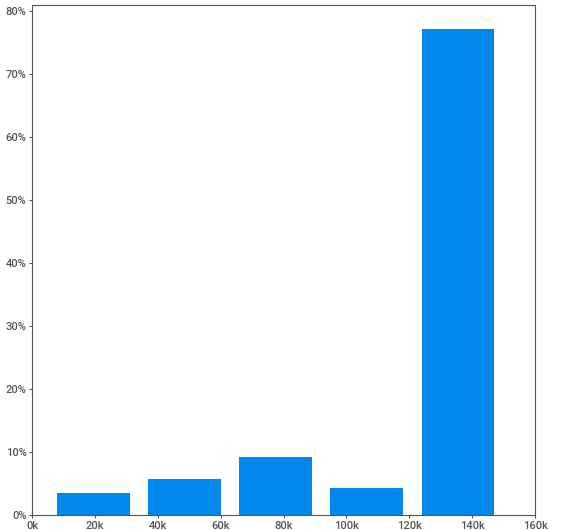
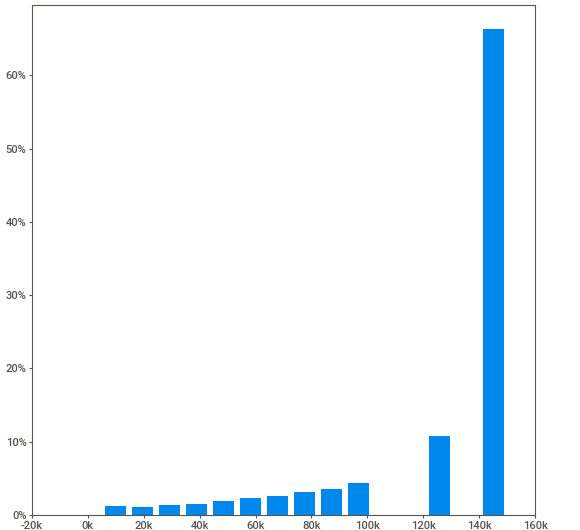
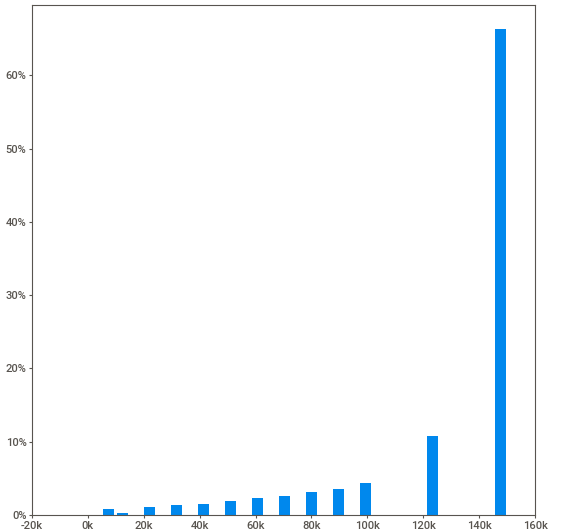
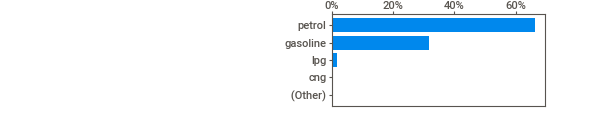
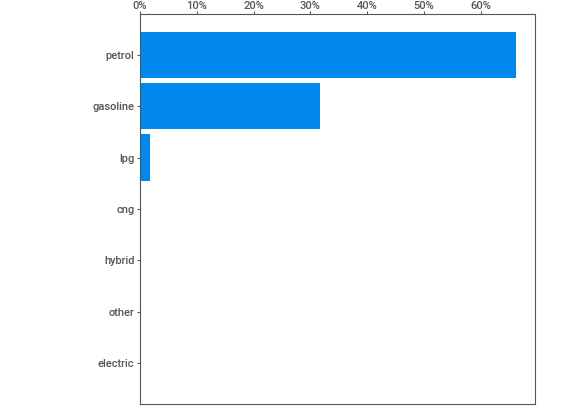
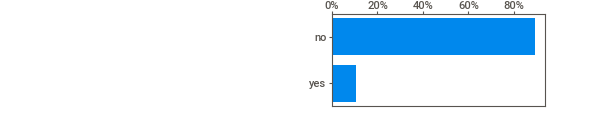
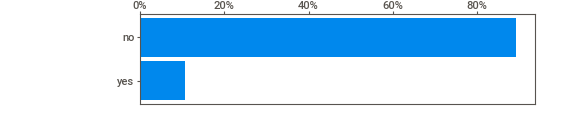
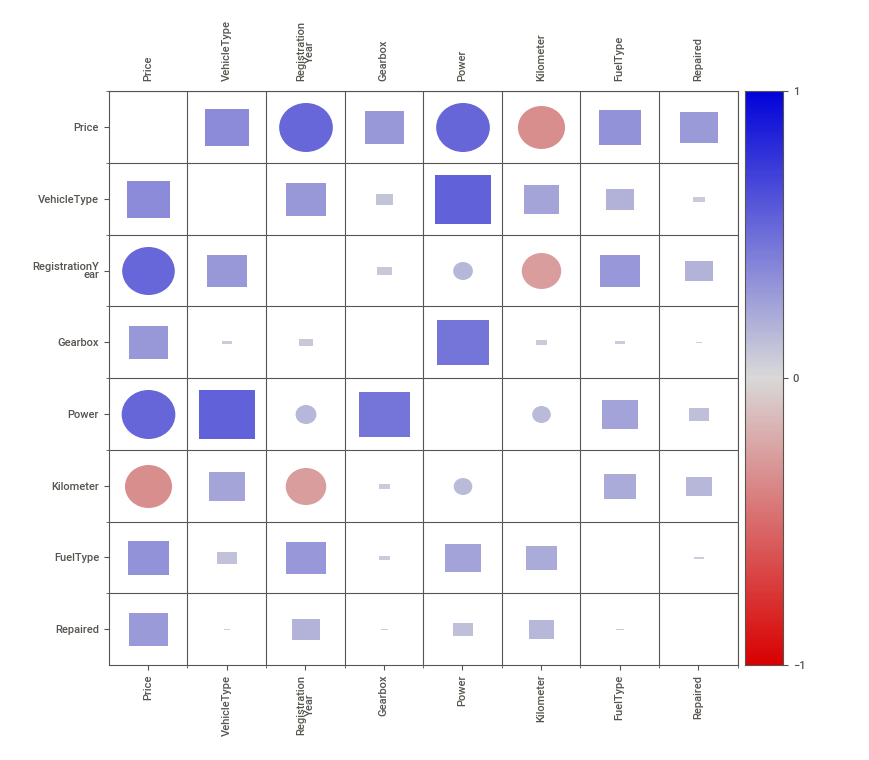
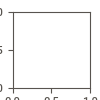

In [19]:
report = sv.analyze(autos)
report.show_notebook()

После удаления неинформативных столбцов и избавления от аномалий количество явных дупликатов увеличилось с 4 до 38757. Удалим эти дубликаты.

In [20]:
autos = autos.drop_duplicates()

In [21]:
autos.duplicated().sum()

0

Проверим категориальные столбцы на наличие неявных дубликатов.

In [22]:
def data_duplicate(data):
    for i in data.columns:
        if data[i].dtypes == 'object':
            data[i] = data[i].str.lower()
            print(f"Столбец '{i}': \n", data[i].unique())

In [23]:
data_duplicate(autos)

Столбец 'VehicleType': 
 ['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'unnknown'
 'other']
Столбец 'Gearbox': 
 ['manual' 'auto' nan]
Столбец 'Model': 
 ['unnknown' 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa'
 'other' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one'
 'fortwo' '1er' 'b_klasse' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito'
 'sprinter' '156' 'escort' 'forester' 'xc_reihe' 'scenic' 'ka' 'a1'
 'focus' 'a4' 'tt' 'astra' 'a6' 'jazz' 'omega' 'slk' '7er' 'combo' 'corsa'
 '80' '147' 'z_reihe' 'sorento' 'ibiza' 'mustang' 'eos' 'touran' 'getz'
 'insignia' 'almera' 'megane' 'a3' 'lupo' 'r19' 'caddy' 'mondeo' 'cordoba'
 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda' 'up'
 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia' 'zafira' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'rio' 'touareg' 'logan'
 'spider' 'cuore' 's_max' 'a2' 'galaxy'

Неявные дубликаты не обнаружены.

**Вывод**
- данные загружены,
- удалены неинформативные признаки,
- проведена работа с аномальными значениями,
- устранена мультиколлинеарность между входными признаками,
- удалены явные дубликаты,
- неявные дубликаты не обнаружены,
- обнаружены пропуски в данных, избавляться от них мы будем с помощью энкодеров.

## Обучение моделей

In [24]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250982 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             250982 non-null  int64 
 1   VehicleType       250982 non-null  object
 2   RegistrationYear  250982 non-null  int64 
 3   Gearbox           246254 non-null  object
 4   Power             250982 non-null  int64 
 5   Model             250982 non-null  object
 6   Kilometer         250982 non-null  int64 
 7   FuelType          237008 non-null  object
 8   Repaired          213472 non-null  object
dtypes: int64(4), object(5)
memory usage: 19.1+ MB


In [25]:
X = autos.drop(['Price'], axis=1)
y = autos['Price']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [26]:
ohe_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

In [28]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [29]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [30]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [31]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 21, 5),
        'models__max_features': range(5, 21, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, silent=True)],
        'models__depth': [5, 10],
        'models__learning_rate': [0.05, 0.1],
        'models__iterations': [100, 200],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 21, 5),
        'models__num_leaves': range(5, 21, 5), 
        'models__learning_rate': [0.01, 0.05, 0.1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [32]:
def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred)) ** 0.5
    
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)

In [33]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=3,
    scoring=rmse_scorer,
    verbose=3
)

In [34]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 219 candidates, totalling 657 fits


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LinearRegression(), preprocessor__num=StandardScaler();, score=-2615.860 total time=  12.6s
[CV 2/3] END models=LinearRegression(), preprocessor__num=StandardScaler();, score=-2625.411 total time=  14.9s
[CV 3/3] END models=LinearRegression(), preprocessor__num=StandardScaler();, score=-2669.576 total time=  12.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LinearRegression(), preprocessor__num=MinMaxScaler();, score=-2615.860 total time=  10.7s
[CV 2/3] END models=LinearRegression(), preprocessor__num=MinMaxScaler();, score=-2625.411 total time=  11.3s
[CV 3/3] END models=LinearRegression(), preprocessor__num=MinMaxScaler();, score=-2669.576 total time=  11.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LinearRegression(), preprocessor__num=passthrough;, score=-2615.860 total time=  14.4s
[CV 2/3] END models=LinearRegression(), preprocessor__num=passthrough;, score=-2625.411 total time=  13.3s
[CV 3/3] END models=LinearRegression(), preprocessor__num=passthrough;, score=-2669.576 total time=  14.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5, preprocessor__num=StandardScaler();, score=-4128.952 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5, preprocessor__num=StandardScaler();, score=-4639.374 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5, preprocessor__num=StandardScaler();, score=-4620.523 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4128.952 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4639.374 total time=   1.8s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4620.523 total time=   1.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5, preprocessor__num=passthrough;, score=-4128.952 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5, preprocessor__num=passthrough;, score=-4639.374 total time=   1.8s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5, preprocessor__num=passthrough;, score=-4620.523 total time=   1.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10, preprocessor__num=StandardScaler();, score=-4160.284 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10, preprocessor__num=StandardScaler();, score=-4512.936 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10, preprocessor__num=StandardScaler();, score=-4501.555 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-4160.284 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-4512.936 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-4501.555 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10, preprocessor__num=passthrough;, score=-4160.284 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10, preprocessor__num=passthrough;, score=-4512.936 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10, preprocessor__num=passthrough;, score=-4501.555 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15, preprocessor__num=StandardScaler();, score=-3545.062 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15, preprocessor__num=StandardScaler();, score=-4453.030 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15, preprocessor__num=StandardScaler();, score=-4441.515 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-3545.062 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-4453.030 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-4441.515 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15, preprocessor__num=passthrough;, score=-3545.062 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15, preprocessor__num=passthrough;, score=-4453.030 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15, preprocessor__num=passthrough;, score=-4441.515 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=20, preprocessor__num=StandardScaler();, score=-3688.109 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=20, preprocessor__num=StandardScaler();, score=-3855.645 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=20, preprocessor__num=StandardScaler();, score=-3797.114 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-3688.109 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-3855.645 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-3797.114 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=20, preprocessor__num=passthrough;, score=-3688.109 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=20, preprocessor__num=passthrough;, score=-3855.645 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=20, preprocessor__num=passthrough;, score=-3797.114 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=5, preprocessor__num=StandardScaler();, score=-4129.236 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=5, preprocessor__num=StandardScaler();, score=-4493.550 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=5, preprocessor__num=StandardScaler();, score=-4487.208 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4129.252 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4493.532 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4487.135 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=5, preprocessor__num=passthrough;, score=-4129.124 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=5, preprocessor__num=passthrough;, score=-4493.531 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=5, preprocessor__num=passthrough;, score=-4487.131 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=10, preprocessor__num=StandardScaler();, score=-3478.064 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=10, preprocessor__num=StandardScaler();, score=-3946.673 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=10, preprocessor__num=StandardScaler();, score=-4066.566 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-3477.926 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-3946.701 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-4066.535 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=10, preprocessor__num=passthrough;, score=-3477.939 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=10, preprocessor__num=passthrough;, score=-3946.643 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=10, preprocessor__num=passthrough;, score=-4066.535 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=15, preprocessor__num=StandardScaler();, score=-3159.450 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=15, preprocessor__num=StandardScaler();, score=-3996.975 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=15, preprocessor__num=StandardScaler();, score=-4134.486 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-3159.464 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-3996.978 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-4134.409 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=15, preprocessor__num=passthrough;, score=-3159.252 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=15, preprocessor__num=passthrough;, score=-3996.998 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=15, preprocessor__num=passthrough;, score=-4134.285 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=20, preprocessor__num=StandardScaler();, score=-3001.612 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=20, preprocessor__num=StandardScaler();, score=-3175.054 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=20, preprocessor__num=StandardScaler();, score=-3641.073 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-3001.551 total time=   2.2s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-3175.047 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-3640.984 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=20, preprocessor__num=passthrough;, score=-3001.654 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=20, preprocessor__num=passthrough;, score=-3175.054 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=10, models__max_features=20, preprocessor__num=passthrough;, score=-3640.744 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=5, preprocessor__num=StandardScaler();, score=-3503.431 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=5, preprocessor__num=StandardScaler();, score=-4379.068 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=5, preprocessor__num=StandardScaler();, score=-4393.493 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-3503.433 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4378.553 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4393.501 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=5, preprocessor__num=passthrough;, score=-3503.440 total time=   1.9s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=5, preprocessor__num=passthrough;, score=-4378.595 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=5, preprocessor__num=passthrough;, score=-4393.544 total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=10, preprocessor__num=StandardScaler();, score=-3144.791 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=10, preprocessor__num=StandardScaler();, score=-3825.194 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=10, preprocessor__num=StandardScaler();, score=-3920.995 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-3144.917 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-3825.425 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-3920.715 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=10, preprocessor__num=passthrough;, score=-3144.900 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=10, preprocessor__num=passthrough;, score=-3825.595 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=10, preprocessor__num=passthrough;, score=-3920.963 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=15, preprocessor__num=StandardScaler();, score=-3012.551 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=15, preprocessor__num=StandardScaler();, score=-3217.464 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=15, preprocessor__num=StandardScaler();, score=-3418.018 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-3012.042 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-3217.679 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-3417.832 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=15, preprocessor__num=passthrough;, score=-3012.639 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=15, preprocessor__num=passthrough;, score=-3217.576 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=15, preprocessor__num=passthrough;, score=-3417.522 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=20, preprocessor__num=StandardScaler();, score=-2702.161 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=20, preprocessor__num=StandardScaler();, score=-3003.401 total time=   2.2s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=20, preprocessor__num=StandardScaler();, score=-2895.184 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-2703.048 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-3003.134 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-2895.297 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=20, preprocessor__num=passthrough;, score=-2702.333 total time=   2.2s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=20, preprocessor__num=passthrough;, score=-3003.606 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=15, models__max_features=20, preprocessor__num=passthrough;, score=-2894.887 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=5, preprocessor__num=StandardScaler();, score=-3685.035 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=5, preprocessor__num=StandardScaler();, score=-4067.607 total time=   1.9s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=5, preprocessor__num=StandardScaler();, score=-4299.645 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-3685.225 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4067.709 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=5, preprocessor__num=MinMaxScaler();, score=-4299.533 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=5, preprocessor__num=passthrough;, score=-3685.377 total time=   2.0s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=5, preprocessor__num=passthrough;, score=-4067.614 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=5, preprocessor__num=passthrough;, score=-4299.661 total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=10, preprocessor__num=StandardScaler();, score=-3008.037 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=10, preprocessor__num=StandardScaler();, score=-3315.961 total time=   2.0s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=10, preprocessor__num=StandardScaler();, score=-3307.334 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-3007.527 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-3315.442 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=10, preprocessor__num=MinMaxScaler();, score=-3308.206 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=10, preprocessor__num=passthrough;, score=-3008.035 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=10, preprocessor__num=passthrough;, score=-3315.823 total time=   2.2s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=10, preprocessor__num=passthrough;, score=-3306.566 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=15, preprocessor__num=StandardScaler();, score=-2692.472 total time=   2.2s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=15, preprocessor__num=StandardScaler();, score=-3334.864 total time=   2.2s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=15, preprocessor__num=StandardScaler();, score=-3212.850 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-2691.616 total time=   2.2s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-3334.602 total time=   2.1s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=15, preprocessor__num=MinMaxScaler();, score=-3213.298 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=15, preprocessor__num=passthrough;, score=-2692.612 total time=   2.1s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=15, preprocessor__num=passthrough;, score=-3335.692 total time=   2.2s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=15, preprocessor__num=passthrough;, score=-3213.140 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=20, preprocessor__num=StandardScaler();, score=-2362.782 total time=   2.2s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=20, preprocessor__num=StandardScaler();, score=-2628.617 total time=   2.2s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=20, preprocessor__num=StandardScaler();, score=-2363.285 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-2361.696 total time=   2.2s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-2629.959 total time=   2.2s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=20, preprocessor__num=MinMaxScaler();, score=-2363.365 total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=20, preprocessor__num=passthrough;, score=-2362.042 total time=   2.3s
[CV 2/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=20, preprocessor__num=passthrough;, score=-2630.289 total time=   2.2s
[CV 3/3] END models=DecisionTreeRegressor(random_state=42), models__max_depth=20, models__max_features=20, preprocessor__num=passthrough;, score=-2362.978 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-2030.502 total time=  17.6s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-2048.704 total time=  17.5s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-2057.803 total time=  17.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-2030.502 total time=  17.7s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-2048.704 total time=  17.3s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-2057.803 total time=  18.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-2030.502 total time=  17.3s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-2048.704 total time=  17.5s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-2057.803 total time=  17.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1921.089 total time=  17.9s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1932.770 total time=  18.0s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1939.999 total time=  19.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1921.087 total time=  17.5s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1932.770 total time=  16.9s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1939.999 total time=  17.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1921.089 total time=  16.9s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1932.770 total time=  17.3s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=100, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1939.999 total time=  17.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-1918.317 total time=  18.6s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-1932.635 total time=  18.1s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-1942.631 total time=  18.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-1918.319 total time=  18.5s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-1932.635 total time=  18.3s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-1942.631 total time=  18.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-1918.317 total time=  18.8s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-1932.637 total time=  18.5s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-1942.631 total time=  18.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1821.986 total time=  18.2s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1836.976 total time=  19.2s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1844.425 total time=  19.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1821.984 total time=  18.5s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1836.976 total time=  19.1s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1844.425 total time=  19.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1821.986 total time=  18.5s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1836.976 total time=  18.6s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=5, models__iterations=200, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1844.425 total time=  18.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-1872.608 total time=  19.6s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-1890.534 total time=  19.3s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-1901.857 total time=  19.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-1872.614 total time=  19.1s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-1890.534 total time=  19.4s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-1901.857 total time=  19.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-1872.608 total time=  20.1s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-1890.534 total time=  19.6s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-1901.857 total time=  19.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1774.388 total time=  19.5s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1797.876 total time=  19.1s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1807.288 total time=  18.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1774.402 total time=  19.5s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1797.876 total time=  19.1s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1807.288 total time=  19.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1774.388 total time=  19.0s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1797.876 total time=  18.9s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=100, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1807.288 total time=  19.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-1777.422 total time=  22.3s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-1795.095 total time=  22.6s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.05, preprocessor__num=StandardScaler();, score=-1808.377 total time=  23.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-1777.431 total time=  23.3s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-1795.095 total time=  23.3s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.05, preprocessor__num=MinMaxScaler();, score=-1808.377 total time=  23.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-1777.422 total time=  23.3s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-1795.095 total time=  23.2s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.05, preprocessor__num=passthrough;, score=-1808.377 total time=  22.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1693.864 total time=  22.8s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1713.636 total time=  22.6s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.1, preprocessor__num=StandardScaler();, score=-1727.858 total time=  23.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1693.880 total time=  23.3s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1713.636 total time=  22.6s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.1, preprocessor__num=MinMaxScaler();, score=-1727.858 total time=  22.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1693.864 total time=  22.5s
[CV 2/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1713.636 total time=  23.2s
[CV 3/3] END models=<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, models__depth=10, models__iterations=200, models__learning_rate=0.1, preprocessor__num=passthrough;, score=-1727.858 total time=  23.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3124.380 total time=   5.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3163.236 total time=   5.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3155.394 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3124.380 total time=   8.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3163.236 total time=   5.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3155.394 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=5, preprocessor__num=passthrough;, score=-3124.380 total time=   4.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=5, preprocessor__num=passthrough;, score=-3163.236 total time=   5.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=5, preprocessor__num=passthrough;, score=-3155.394 total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2902.705 total time=   5.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2934.405 total time=   6.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2926.967 total time=   6.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2902.711 total time=   6.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2934.405 total time=   8.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2926.966 total time=   8.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=10, preprocessor__num=passthrough;, score=-2902.711 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=10, preprocessor__num=passthrough;, score=-2934.405 total time=   6.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=10, preprocessor__num=passthrough;, score=-2926.966 total time=   5.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2812.770 total time=   6.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2843.752 total time=   7.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2835.779 total time=   6.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2812.770 total time=   6.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2843.752 total time=   6.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2836.420 total time=   6.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=15, preprocessor__num=passthrough;, score=-2812.770 total time=   5.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=15, preprocessor__num=passthrough;, score=-2843.738 total time=   7.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=15, preprocessor__num=passthrough;, score=-2836.420 total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2761.541 total time=   9.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2793.387 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2783.415 total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2761.474 total time=   6.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2793.387 total time=  11.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2783.278 total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=20, preprocessor__num=passthrough;, score=-2761.474 total time=  39.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=20, preprocessor__num=passthrough;, score=-2793.388 total time=   6.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=5, models__num_leaves=20, preprocessor__num=passthrough;, score=-2783.278 total time=   7.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3124.380 total time=   4.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3163.236 total time=   5.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3155.394 total time=   6.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3124.380 total time=   6.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3163.236 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3155.394 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=5, preprocessor__num=passthrough;, score=-3124.380 total time=   4.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=5, preprocessor__num=passthrough;, score=-3163.236 total time=   5.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=5, preprocessor__num=passthrough;, score=-3155.394 total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2902.705 total time=   8.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2933.787 total time=   5.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2928.486 total time=   6.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2902.711 total time=   6.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2933.787 total time=   5.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2928.485 total time=   6.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=10, preprocessor__num=passthrough;, score=-2902.711 total time=   5.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=10, preprocessor__num=passthrough;, score=-2933.787 total time=   6.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=10, preprocessor__num=passthrough;, score=-2928.485 total time=   6.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2808.772 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2837.468 total time=   6.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2830.741 total time=   6.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2808.775 total time=   6.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2837.737 total time=   6.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2830.747 total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=15, preprocessor__num=passthrough;, score=-2808.775 total time=   7.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=15, preprocessor__num=passthrough;, score=-2837.739 total time= 1.1min
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=15, preprocessor__num=passthrough;, score=-2830.747 total time= 1.4min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2754.330 total time= 1.2min
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2783.547 total time= 1.5min
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2776.515 total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2754.577 total time= 1.3min
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2783.568 total time= 1.5min
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2776.910 total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=20, preprocessor__num=passthrough;, score=-2754.577 total time= 2.4min
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=20, preprocessor__num=passthrough;, score=-2783.568 total time=  13.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=10, models__num_leaves=20, preprocessor__num=passthrough;, score=-2776.910 total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3124.380 total time=   5.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3163.236 total time=   4.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3155.394 total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3124.380 total time=   4.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3163.236 total time=   4.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3155.394 total time=   5.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=5, preprocessor__num=passthrough;, score=-3124.380 total time=   5.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=5, preprocessor__num=passthrough;, score=-3163.236 total time=   7.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=5, preprocessor__num=passthrough;, score=-3155.394 total time=   5.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2902.705 total time=   5.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2933.787 total time=   6.3s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2928.486 total time=   6.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2902.711 total time=   6.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2933.787 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2928.485 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=10, preprocessor__num=passthrough;, score=-2902.711 total time=  15.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=10, preprocessor__num=passthrough;, score=-2933.787 total time= 2.2min
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=10, preprocessor__num=passthrough;, score=-2928.485 total time= 2.8min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2808.772 total time= 3.2min
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2837.468 total time= 4.3min
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2830.741 total time= 4.4min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2808.775 total time= 3.3min
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2837.737 total time= 3.3min
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2830.747 total time= 3.1min


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=15, preprocessor__num=passthrough;, score=-2808.775 total time=   7.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=15, preprocessor__num=passthrough;, score=-2837.739 total time= 3.3min
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=15, preprocessor__num=passthrough;, score=-2830.747 total time=   6.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2754.330 total time=   6.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2783.547 total time=   8.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2776.515 total time=   7.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2754.577 total time=   7.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2783.568 total time=  12.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2776.910 total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=20, preprocessor__num=passthrough;, score=-2754.577 total time=   9.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=20, preprocessor__num=passthrough;, score=-2783.568 total time= 3.1min
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=15, models__num_leaves=20, preprocessor__num=passthrough;, score=-2776.910 total time=   7.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3124.380 total time=   5.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3163.236 total time=   5.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-3155.394 total time=   5.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3124.380 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3163.236 total time=   8.3s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-3155.394 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=5, preprocessor__num=passthrough;, score=-3124.380 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=5, preprocessor__num=passthrough;, score=-3163.236 total time=   5.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=5, preprocessor__num=passthrough;, score=-3155.394 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2902.705 total time=   6.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2933.787 total time=   6.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2928.486 total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2902.711 total time=   6.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2933.787 total time=   5.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2928.485 total time=   7.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=10, preprocessor__num=passthrough;, score=-2902.711 total time=   5.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=10, preprocessor__num=passthrough;, score=-2933.787 total time=   6.3s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=10, preprocessor__num=passthrough;, score=-2928.485 total time=   5.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2808.772 total time=   6.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2837.468 total time=   6.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-2830.741 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2808.775 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2837.737 total time=   6.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-2830.747 total time=  13.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=15, preprocessor__num=passthrough;, score=-2808.775 total time=   6.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=15, preprocessor__num=passthrough;, score=-2837.739 total time=   7.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=15, preprocessor__num=passthrough;, score=-2830.747 total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2754.330 total time=   6.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2783.547 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-2776.515 total time=   7.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2754.577 total time=   7.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2783.568 total time=   6.7s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-2776.910 total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=20, preprocessor__num=passthrough;, score=-2754.577 total time=   8.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=20, preprocessor__num=passthrough;, score=-2783.568 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.01, models__max_depth=20, models__num_leaves=20, preprocessor__num=passthrough;, score=-2776.910 total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2119.827 total time=   5.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2139.950 total time=   4.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2146.211 total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2120.072 total time=   5.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2139.287 total time=   5.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2146.255 total time=   5.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=5, preprocessor__num=passthrough;, score=-2120.072 total time=   6.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=5, preprocessor__num=passthrough;, score=-2139.287 total time=   5.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=5, preprocessor__num=passthrough;, score=-2146.255 total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1976.408 total time=   5.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1999.322 total time=   6.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-2007.830 total time=   5.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1974.576 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2000.850 total time=   5.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2007.135 total time=   5.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=10, preprocessor__num=passthrough;, score=-1974.576 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=10, preprocessor__num=passthrough;, score=-2000.850 total time=   5.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=10, preprocessor__num=passthrough;, score=-2007.135 total time=   7.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1931.938 total time=   9.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1946.333 total time= 2.7min
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1958.874 total time=  26.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1930.872 total time=   8.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1947.807 total time=   6.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1958.515 total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=15, preprocessor__num=passthrough;, score=-1930.872 total time=   6.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=15, preprocessor__num=passthrough;, score=-1950.935 total time=   6.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=15, preprocessor__num=passthrough;, score=-1958.515 total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1905.872 total time=   6.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1927.862 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1936.451 total time=   7.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1907.577 total time=   6.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1926.442 total time=   6.3s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1936.400 total time=   7.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=20, preprocessor__num=passthrough;, score=-1907.577 total time=   6.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=20, preprocessor__num=passthrough;, score=-1926.442 total time=   7.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=5, models__num_leaves=20, preprocessor__num=passthrough;, score=-1936.400 total time=   8.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2119.827 total time=   4.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2139.950 total time=   5.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2146.211 total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2120.072 total time=   5.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2139.287 total time=   4.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2146.255 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=5, preprocessor__num=passthrough;, score=-2120.072 total time=   7.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=5, preprocessor__num=passthrough;, score=-2139.287 total time=   5.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=5, preprocessor__num=passthrough;, score=-2146.255 total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1968.760 total time=   6.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1989.349 total time=   6.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1999.921 total time=   7.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1966.676 total time=   6.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1990.929 total time=   6.3s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2002.191 total time=   6.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=10, preprocessor__num=passthrough;, score=-1966.676 total time=   5.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=10, preprocessor__num=passthrough;, score=-1990.929 total time=  10.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=10, preprocessor__num=passthrough;, score=-2002.191 total time=   6.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1909.121 total time=   6.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1925.315 total time=   6.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1935.256 total time=   6.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1909.377 total time=   6.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1925.749 total time=   6.7s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1936.078 total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=15, preprocessor__num=passthrough;, score=-1909.377 total time=   6.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=15, preprocessor__num=passthrough;, score=-1925.749 total time=   7.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=15, preprocessor__num=passthrough;, score=-1936.078 total time=   8.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1873.372 total time=   8.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1889.530 total time=   6.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1901.110 total time=   7.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1873.163 total time=   6.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1891.139 total time=   9.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1900.754 total time=   6.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=20, preprocessor__num=passthrough;, score=-1873.163 total time=   7.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=20, preprocessor__num=passthrough;, score=-1891.139 total time=   8.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=10, models__num_leaves=20, preprocessor__num=passthrough;, score=-1900.754 total time=   6.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2119.827 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2139.950 total time=   5.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2146.211 total time=   4.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2120.072 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2139.287 total time=   6.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2146.255 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=5, preprocessor__num=passthrough;, score=-2120.072 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=5, preprocessor__num=passthrough;, score=-2139.287 total time=   5.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=5, preprocessor__num=passthrough;, score=-2146.255 total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1968.760 total time=  10.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1989.349 total time=   7.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1999.921 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1966.676 total time=   5.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1990.929 total time=   5.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2002.191 total time=   5.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=10, preprocessor__num=passthrough;, score=-1966.676 total time=   6.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=10, preprocessor__num=passthrough;, score=-1990.929 total time=  11.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=10, preprocessor__num=passthrough;, score=-2002.191 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1907.076 total time=   9.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1922.705 total time=   9.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1934.097 total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1906.437 total time=   6.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1924.071 total time=   6.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1934.599 total time=   6.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=15, preprocessor__num=passthrough;, score=-1906.437 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=15, preprocessor__num=passthrough;, score=-1924.071 total time=   7.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=15, preprocessor__num=passthrough;, score=-1934.599 total time=   5.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1867.985 total time=   7.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1886.492 total time=   7.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1895.615 total time=   7.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1868.143 total time=   6.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1886.650 total time=   7.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1894.599 total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=20, preprocessor__num=passthrough;, score=-1868.143 total time=   7.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=20, preprocessor__num=passthrough;, score=-1886.650 total time=   7.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=15, models__num_leaves=20, preprocessor__num=passthrough;, score=-1894.599 total time=   8.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2119.827 total time=   5.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2139.950 total time=   5.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2146.211 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2120.072 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2139.287 total time=   4.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2146.255 total time=   5.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=5, preprocessor__num=passthrough;, score=-2120.072 total time=   5.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=5, preprocessor__num=passthrough;, score=-2139.287 total time=   5.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=5, preprocessor__num=passthrough;, score=-2146.255 total time=   5.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1968.760 total time=   6.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1989.349 total time=   5.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1999.921 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1966.676 total time=   8.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1990.929 total time=   6.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-2002.191 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=10, preprocessor__num=passthrough;, score=-1966.676 total time=   5.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=10, preprocessor__num=passthrough;, score=-1990.929 total time=  10.3s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=10, preprocessor__num=passthrough;, score=-2002.191 total time=   6.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1907.076 total time=   5.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1922.705 total time=   6.7s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1934.097 total time=   6.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1906.437 total time=   6.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1924.071 total time=   6.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1934.599 total time=   9.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=15, preprocessor__num=passthrough;, score=-1906.437 total time=   5.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=15, preprocessor__num=passthrough;, score=-1924.071 total time=   6.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=15, preprocessor__num=passthrough;, score=-1934.599 total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1866.980 total time=   6.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1885.595 total time=   7.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1895.259 total time=   7.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1867.963 total time=   8.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1886.526 total time=   7.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1894.386 total time=   7.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=20, preprocessor__num=passthrough;, score=-1867.963 total time=  10.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=20, preprocessor__num=passthrough;, score=-1886.526 total time=   7.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.05, models__max_depth=20, models__num_leaves=20, preprocessor__num=passthrough;, score=-1894.386 total time=   7.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-1991.177 total time=   5.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2012.619 total time=   5.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2023.066 total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-1991.301 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2011.804 total time=   5.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2023.083 total time=   5.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=5, preprocessor__num=passthrough;, score=-1991.301 total time=   4.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=5, preprocessor__num=passthrough;, score=-2011.804 total time=   4.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=5, preprocessor__num=passthrough;, score=-2023.083 total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1879.505 total time=   5.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1903.111 total time=   5.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1915.306 total time=   5.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1879.181 total time=   7.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1902.438 total time=   5.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1914.815 total time=   5.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=10, preprocessor__num=passthrough;, score=-1879.181 total time=   5.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=10, preprocessor__num=passthrough;, score=-1902.438 total time=   5.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=10, preprocessor__num=passthrough;, score=-1914.815 total time=  10.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1849.168 total time=   8.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1861.130 total time=   8.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1876.898 total time=   5.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1847.483 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1861.140 total time=   5.7s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1877.174 total time=   7.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=15, preprocessor__num=passthrough;, score=-1847.483 total time=   5.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=15, preprocessor__num=passthrough;, score=-1861.207 total time=   7.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=15, preprocessor__num=passthrough;, score=-1877.174 total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1830.633 total time=   5.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1847.912 total time=   6.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1861.170 total time=   7.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1834.045 total time=   6.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1844.471 total time=   5.7s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1860.216 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=20, preprocessor__num=passthrough;, score=-1834.045 total time=   6.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=20, preprocessor__num=passthrough;, score=-1844.471 total time=   5.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=5, models__num_leaves=20, preprocessor__num=passthrough;, score=-1860.216 total time=  11.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-1991.177 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2012.619 total time=   5.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2023.066 total time=   5.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-1991.301 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2011.804 total time=   5.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2023.083 total time=   5.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=5, preprocessor__num=passthrough;, score=-1991.301 total time=   5.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=5, preprocessor__num=passthrough;, score=-2011.804 total time=   5.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=5, preprocessor__num=passthrough;, score=-2023.083 total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1865.353 total time=   5.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1890.069 total time=   6.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1901.859 total time=   7.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1865.493 total time=   5.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1890.075 total time=   5.7s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1902.857 total time=   5.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=10, preprocessor__num=passthrough;, score=-1865.493 total time=   5.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=10, preprocessor__num=passthrough;, score=-1890.075 total time=   5.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=10, preprocessor__num=passthrough;, score=-1902.857 total time=   5.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1812.006 total time=   6.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1825.364 total time=   6.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1843.011 total time=   7.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1812.033 total time=   6.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1825.022 total time=   6.7s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1837.410 total time=   6.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=15, preprocessor__num=passthrough;, score=-1812.033 total time=   6.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=15, preprocessor__num=passthrough;, score=-1825.022 total time=   6.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=15, preprocessor__num=passthrough;, score=-1837.410 total time=   6.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1782.080 total time=   6.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1794.116 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1810.547 total time=   6.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1781.350 total time=   6.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1792.504 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1812.065 total time=   7.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=20, preprocessor__num=passthrough;, score=-1781.350 total time=   7.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=20, preprocessor__num=passthrough;, score=-1792.267 total time=   7.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=10, models__num_leaves=20, preprocessor__num=passthrough;, score=-1812.065 total time=   7.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-1991.177 total time=   4.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2012.619 total time=   4.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2023.066 total time=   5.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-1991.301 total time=   5.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2011.804 total time=   4.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2023.083 total time=   5.1s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=5, preprocessor__num=passthrough;, score=-1991.301 total time=   5.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=5, preprocessor__num=passthrough;, score=-2011.804 total time=   4.3s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=5, preprocessor__num=passthrough;, score=-2023.083 total time=   7.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1865.353 total time=   5.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1890.069 total time=   5.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1901.859 total time=   5.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1865.493 total time=  14.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1890.075 total time=   5.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1902.857 total time=   5.6s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=10, preprocessor__num=passthrough;, score=-1865.493 total time=   6.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=10, preprocessor__num=passthrough;, score=-1890.075 total time=   6.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=10, preprocessor__num=passthrough;, score=-1902.857 total time=   5.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1808.841 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1822.734 total time=   8.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1838.697 total time=   7.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1807.519 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1823.323 total time=   6.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1838.466 total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=15, preprocessor__num=passthrough;, score=-1807.519 total time=   9.1s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=15, preprocessor__num=passthrough;, score=-1823.395 total time=   7.2s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=15, preprocessor__num=passthrough;, score=-1838.466 total time=   7.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1772.697 total time=   7.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1782.267 total time=   7.0s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1799.729 total time=   7.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1771.732 total time=   7.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1783.194 total time=   7.7s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1801.103 total time=   7.5s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=20, preprocessor__num=passthrough;, score=-1771.732 total time=   7.0s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=20, preprocessor__num=passthrough;, score=-1782.728 total time=   7.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=15, models__num_leaves=20, preprocessor__num=passthrough;, score=-1801.103 total time=   6.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-1991.177 total time=   4.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2012.619 total time=  10.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=5, preprocessor__num=StandardScaler();, score=-2023.066 total time=   5.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-1991.301 total time=   4.6s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2011.804 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=5, preprocessor__num=MinMaxScaler();, score=-2023.083 total time=   4.7s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=5, preprocessor__num=passthrough;, score=-1991.301 total time=   5.2s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=5, preprocessor__num=passthrough;, score=-2011.804 total time=   5.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=5, preprocessor__num=passthrough;, score=-2023.083 total time=   4.8s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1865.353 total time=   5.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1890.069 total time=   5.4s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=10, preprocessor__num=StandardScaler();, score=-1901.859 total time=   5.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1865.493 total time=   5.5s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1890.075 total time=   5.3s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=10, preprocessor__num=MinMaxScaler();, score=-1902.857 total time=   5.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=10, preprocessor__num=passthrough;, score=-1865.493 total time=   6.4s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=10, preprocessor__num=passthrough;, score=-1890.075 total time=   5.7s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=10, preprocessor__num=passthrough;, score=-1902.857 total time=   6.0s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1808.841 total time=   5.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1822.734 total time=   9.1s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=15, preprocessor__num=StandardScaler();, score=-1838.697 total time=   6.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1807.519 total time=  11.3s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1823.323 total time=   6.5s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=15, preprocessor__num=MinMaxScaler();, score=-1838.466 total time=   8.4s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=15, preprocessor__num=passthrough;, score=-1807.519 total time=   5.9s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=15, preprocessor__num=passthrough;, score=-1823.395 total time=   9.6s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=15, preprocessor__num=passthrough;, score=-1838.466 total time=   6.3s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1771.772 total time=   6.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1782.621 total time=   6.8s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=20, preprocessor__num=StandardScaler();, score=-1798.609 total time=   7.2s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1772.102 total time=   8.8s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1781.090 total time=   7.3s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=20, preprocessor__num=MinMaxScaler();, score=-1797.853 total time=   8.9s


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=20, preprocessor__num=passthrough;, score=-1772.102 total time=   6.7s
[CV 2/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=20, preprocessor__num=passthrough;, score=-1781.090 total time=   6.9s
[CV 3/3] END models=LGBMRegressor(random_state=42), models__learning_rate=0.1, models__max_depth=20, models__num_leaves=20, preprocessor__num=passthrough;, score=-1797.853 total time=   7.8s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Repaired']),
                                                                        ('num',
                                                                         Sta...
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LGBMRegressor(random_state=42)],
                          'models__learning_rate': [0.01, 0.05, 0.1],
                          'models__max_depth': range(5, 21, 5),
                          'models__num_leaves': range(5, 21, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
             verbose=3)

**Вывод** таким образом, для проекта использовались 4 модели LinearRegression(), CatBoostRegressor(), LGBMRegressor(), DecisionTreeRegressor(). Использовался метод с кросс-валидацией с перебором параметров.

## Анализ моделей

Выведем лучшие параметры для каждой модели, cреднюю метрику по кросс-валидации и среднюю скорость обучения по кросс-валидации.

In [35]:
results = pd.DataFrame(grid_search.cv_results_)
pd.set_option('display.max_colwidth', None)

results['model_type'] = results['param_models'].apply(lambda x: x.__class__.__name__)

best_params_per_model = results.loc[results.groupby('model_type')['rank_test_score'].idxmin()]

display(best_params_per_model[['param_models', 'params', 'mean_test_score', 'mean_fit_time']])

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)

,param_models,params,mean_test_score,mean_fit_time
72,<catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>,"{'models': <catboost.core.CatBoostRegressor object at 0x7f2f54aa7e80>, 'models__depth': 10, 'models__iterations': 200, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}",-1711.785984,18.138519
48,DecisionTreeRegressor(random_state=42),"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 20, 'models__max_features': 20, 'preprocessor__num': StandardScaler()}",-2451.561244,1.717269
218,LGBMRegressor(random_state=42),"{'models': LGBMRegressor(random_state=42), 'models__learning_rate': 0.1, 'models__max_depth': 20, 'models__num_leaves': 20, 'preprocessor__num': 'passthrough'}",-1783.681693,6.017868
0,LinearRegression(),"{'models': LinearRegression(), 'preprocessor__num': StandardScaler()}",-2636.949082,12.855471


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired']),
                          

Выберем модель CatBoost так как у неё самая высокая точность.

In [36]:
%%time
y_pred = grid_search.predict(X_test)
print(f'Метрика rmse на тестовой выборке: {rmse(y_test, y_pred)}')

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Метрика rmse на тестовой выборке: 1684.8865441310547
CPU times: user 4.68 s, sys: 190 ms, total: 4.87 s
Wall time: 4.89 s


**Вывод** на тестовой выборке значение rmse 1685, что меньше 2500.

## Итоговый вывод

Работа с данными:
- в данных присутствовали неинформативные признаки, которые были удалены,
- проведена работа с аномальными значениями, неправдаподобные данные исключеныиз датасета,
- присутствовала мультиколлинеарность между входными признаками, которая была устранена,
- удалены явные дубликаты,
- неявные дубликаты не обнаружены,
- пропуски в данных заполнены заглушкой или обработаны в энкодере.

В резульате кросс-валидации выбор стоял между моделями CatBoost и LightGBM. Была выбрана для предсказаний на тестовых данных модель CatBoost, так как её точность выше. Стоит заметить, что время обчения модели LightGBM проходит быстрее. Но у нас в приоритете точность.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей